## Requirements and Imports


In [1]:
import copy
import os
from pathlib import Path
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_auc_score , pairwise_distances
import torch
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import scipy.sparse as sp
from numba import jit
from Annotatability import models
from Annotatability import metrics
import scPrisma
device

device(type='cpu')

In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 21
BIGGER_SIZE = 24
#plt.rcParams["font.family"] = "Verdana"
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sc.set_figure_params(scanpy=True, fontsize=22)


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


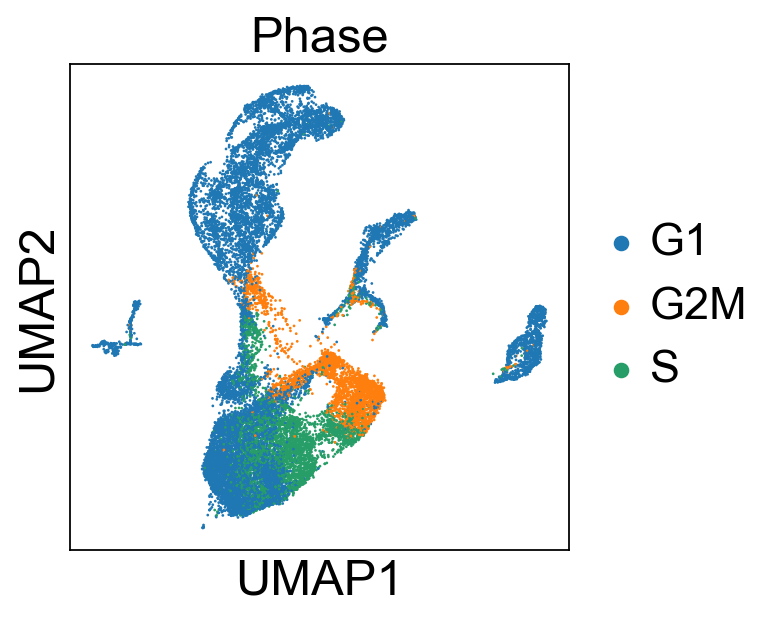

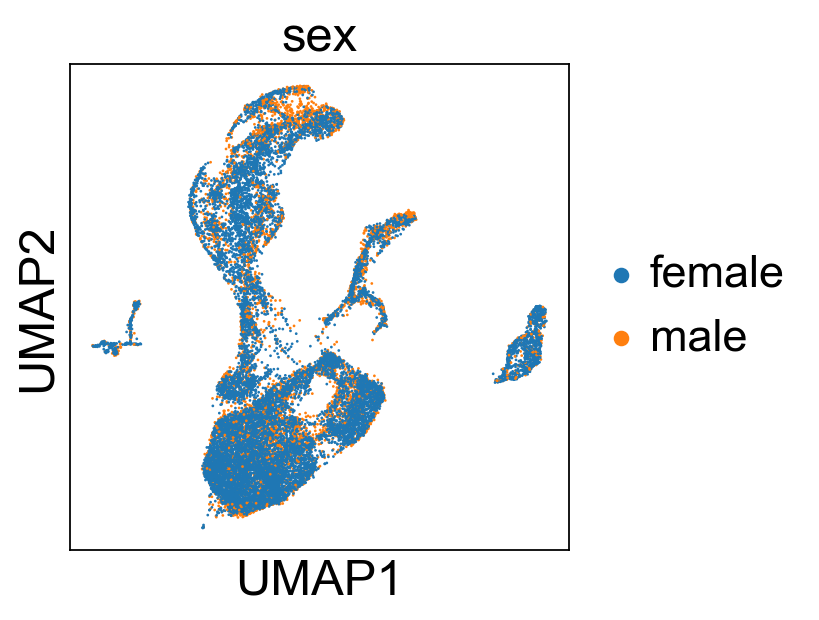

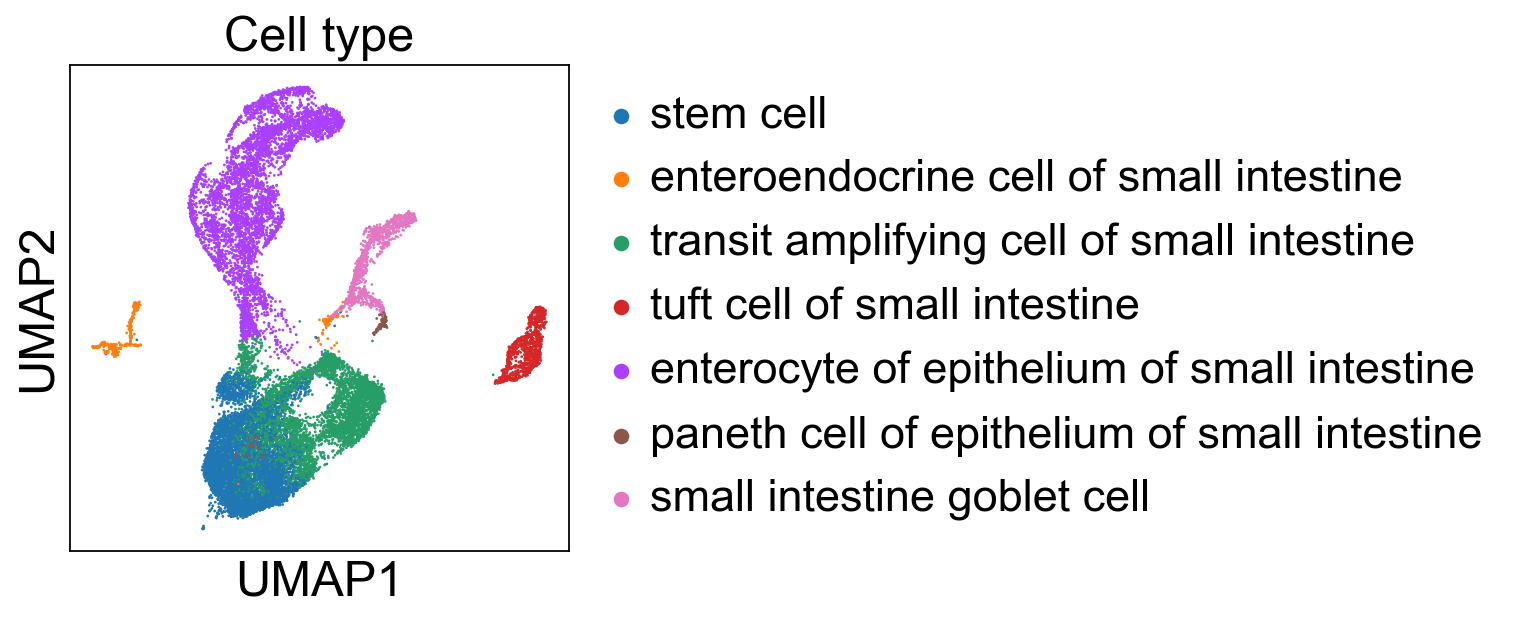

AnnData object with n_obs × n_vars = 19847 × 3000
    obs: 'orig.ident', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'cell.type', 'segment', 'percent.mt', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_counts', 'Cell type'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'means', 'dispersions', 'dispersions_norm'
    uns: 'citation', 'schema_reference', 'schema_version', 'title', 'log1p', 'pca', 'neighbors', 'umap', 'Phase_colors', 'sex_colors', 'Cell type_colors'
    obsm: 'X_umap', 'umap', 'X_pca'
    varm: 'PCs'
    

In [3]:
import scanpy as sc
import requests
from io import BytesIO
# Epithelial cells collected from 30 segments across the proximal (1) to distal (30) ends of the mouse small intestine.


url = "https://datasets.cellxgene.cziscience.com/dbc3f084-1640-4c47-817f-c4f77e09afaa.h5ad"

# Download the h5ad file
response = requests.get(url)

# Read the downloaded content into a BytesIO object
h5ad_data = BytesIO(response.content)

# Read the h5ad data using read_h5ad function
adata = sc.read_h5ad(h5ad_data)
#adata =  adata[adata.obs['cell_type'].isin([
# 'enterocyte of epithelium of small intestine'])]

adata.X = adata.X.toarray()
# Normalizing to median total counts
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# Logarithmize the data
sc.pp.log1p(adata)
sc.pp.filter_genes_dispersion(adata, n_top_genes=3000)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Phase'])
sc.pl.umap(adata, color=['sex'])
adata.obs['Cell type']= adata.obs['cell_type']
sc.pl.umap(adata, color=['Cell type'])

adata


In [22]:
adata.obs['Spatial segment'] = np.array(adata.obs['segment']).astype(int)
def assign_cluster(segment):
    if 1 <= segment <= 2:
        return 'A-[1,2]'
    elif 3 <= segment <= 9:
        return 'B-[3,9]'
    elif 10 <= segment <= 17:
        return 'C-[10,17]'
    elif 18 <= segment <= 24:
        return 'D-[18,24]'
    elif 25 <= segment <= 30:
        return 'E-[25,30]'
    else:
        return 'Out of range'

# Apply the function to create the 'segment cluster' column
adata.obs['segment domain'] = adata.obs['Spatial segment'].apply(assign_cluster)


In [5]:

epoch_num=50
prob_list = models.follow_training_dyn_neural_net(adata, label_key='cell_type',iterNum=epoch_num, device=device)

[1,     2] loss: 0.390
[1,    12] loss: 1.928
[1,    22] loss: 1.877
[1,    32] loss: 1.802
[1,    42] loss: 1.718
[1,    52] loss: 1.629
[1,    62] loss: 1.514
[1,    72] loss: 1.403
[2,     2] loss: 0.246
[2,    12] loss: 1.171
[2,    22] loss: 1.045
[2,    32] loss: 0.933
[2,    42] loss: 0.833
[2,    52] loss: 0.762
[2,    62] loss: 0.684
[2,    72] loss: 0.661
[3,     2] loss: 0.124
[3,    12] loss: 0.570
[3,    22] loss: 0.557
[3,    32] loss: 0.514
[3,    42] loss: 0.503
[3,    52] loss: 0.475
[3,    62] loss: 0.471
[3,    72] loss: 0.439
[4,     2] loss: 0.088
[4,    12] loss: 0.410
[4,    22] loss: 0.393
[4,    32] loss: 0.379
[4,    42] loss: 0.355
[4,    52] loss: 0.364
[4,    62] loss: 0.346
[4,    72] loss: 0.321
[5,     2] loss: 0.062
[5,    12] loss: 0.303
[5,    22] loss: 0.297
[5,    32] loss: 0.309
[5,    42] loss: 0.280
[5,    52] loss: 0.279
[5,    62] loss: 0.274
[5,    72] loss: 0.275
[6,     2] loss: 0.052
[6,    12] loss: 0.262
[6,    22] loss: 0.251
[6,    32] 

[44,    12] loss: 0.062
[44,    22] loss: 0.061
[44,    32] loss: 0.069
[44,    42] loss: 0.053
[44,    52] loss: 0.055
[44,    62] loss: 0.048
[44,    72] loss: 0.060
[45,     2] loss: 0.007
[45,    12] loss: 0.060
[45,    22] loss: 0.062
[45,    32] loss: 0.058
[45,    42] loss: 0.070
[45,    52] loss: 0.066
[45,    62] loss: 0.056
[45,    72] loss: 0.058
[46,     2] loss: 0.012
[46,    12] loss: 0.067
[46,    22] loss: 0.060
[46,    32] loss: 0.047
[46,    42] loss: 0.050
[46,    52] loss: 0.060
[46,    62] loss: 0.056
[46,    72] loss: 0.055
[47,     2] loss: 0.013
[47,    12] loss: 0.056
[47,    22] loss: 0.057
[47,    32] loss: 0.060
[47,    42] loss: 0.059
[47,    52] loss: 0.056
[47,    62] loss: 0.061
[47,    72] loss: 0.057
[48,     2] loss: 0.012
[48,    12] loss: 0.064
[48,    22] loss: 0.063
[48,    32] loss: 0.055
[48,    42] loss: 0.059
[48,    52] loss: 0.059
[48,    62] loss: 0.060
[48,    72] loss: 0.060
[49,     2] loss: 0.015
[49,    12] loss: 0.057
[49,    22] loss

In [6]:
all_conf_cell_type , all_var_cell_type = models.probability_list_to_confidence_and_var(prob_list, n_obs= adata.n_obs, epoch_num=epoch_num)

In [7]:
adata.obs["var"] = all_var_cell_type.detach().numpy()
adata.obs["conf"] = all_conf_cell_type.detach().numpy()
adata.obs["var_celltype"] = all_var_cell_type.detach().numpy()
adata.obs["conf_celltype"] = all_conf_cell_type.detach().numpy()

In [8]:
print(np.var(all_var_cell_type.detach().numpy()))
print(np.var(all_conf_cell_type.detach().numpy()))

0.0011367801
0.02888977


In [9]:
print(np.var(all_var_cell_type.detach().numpy()))


0.0011367801


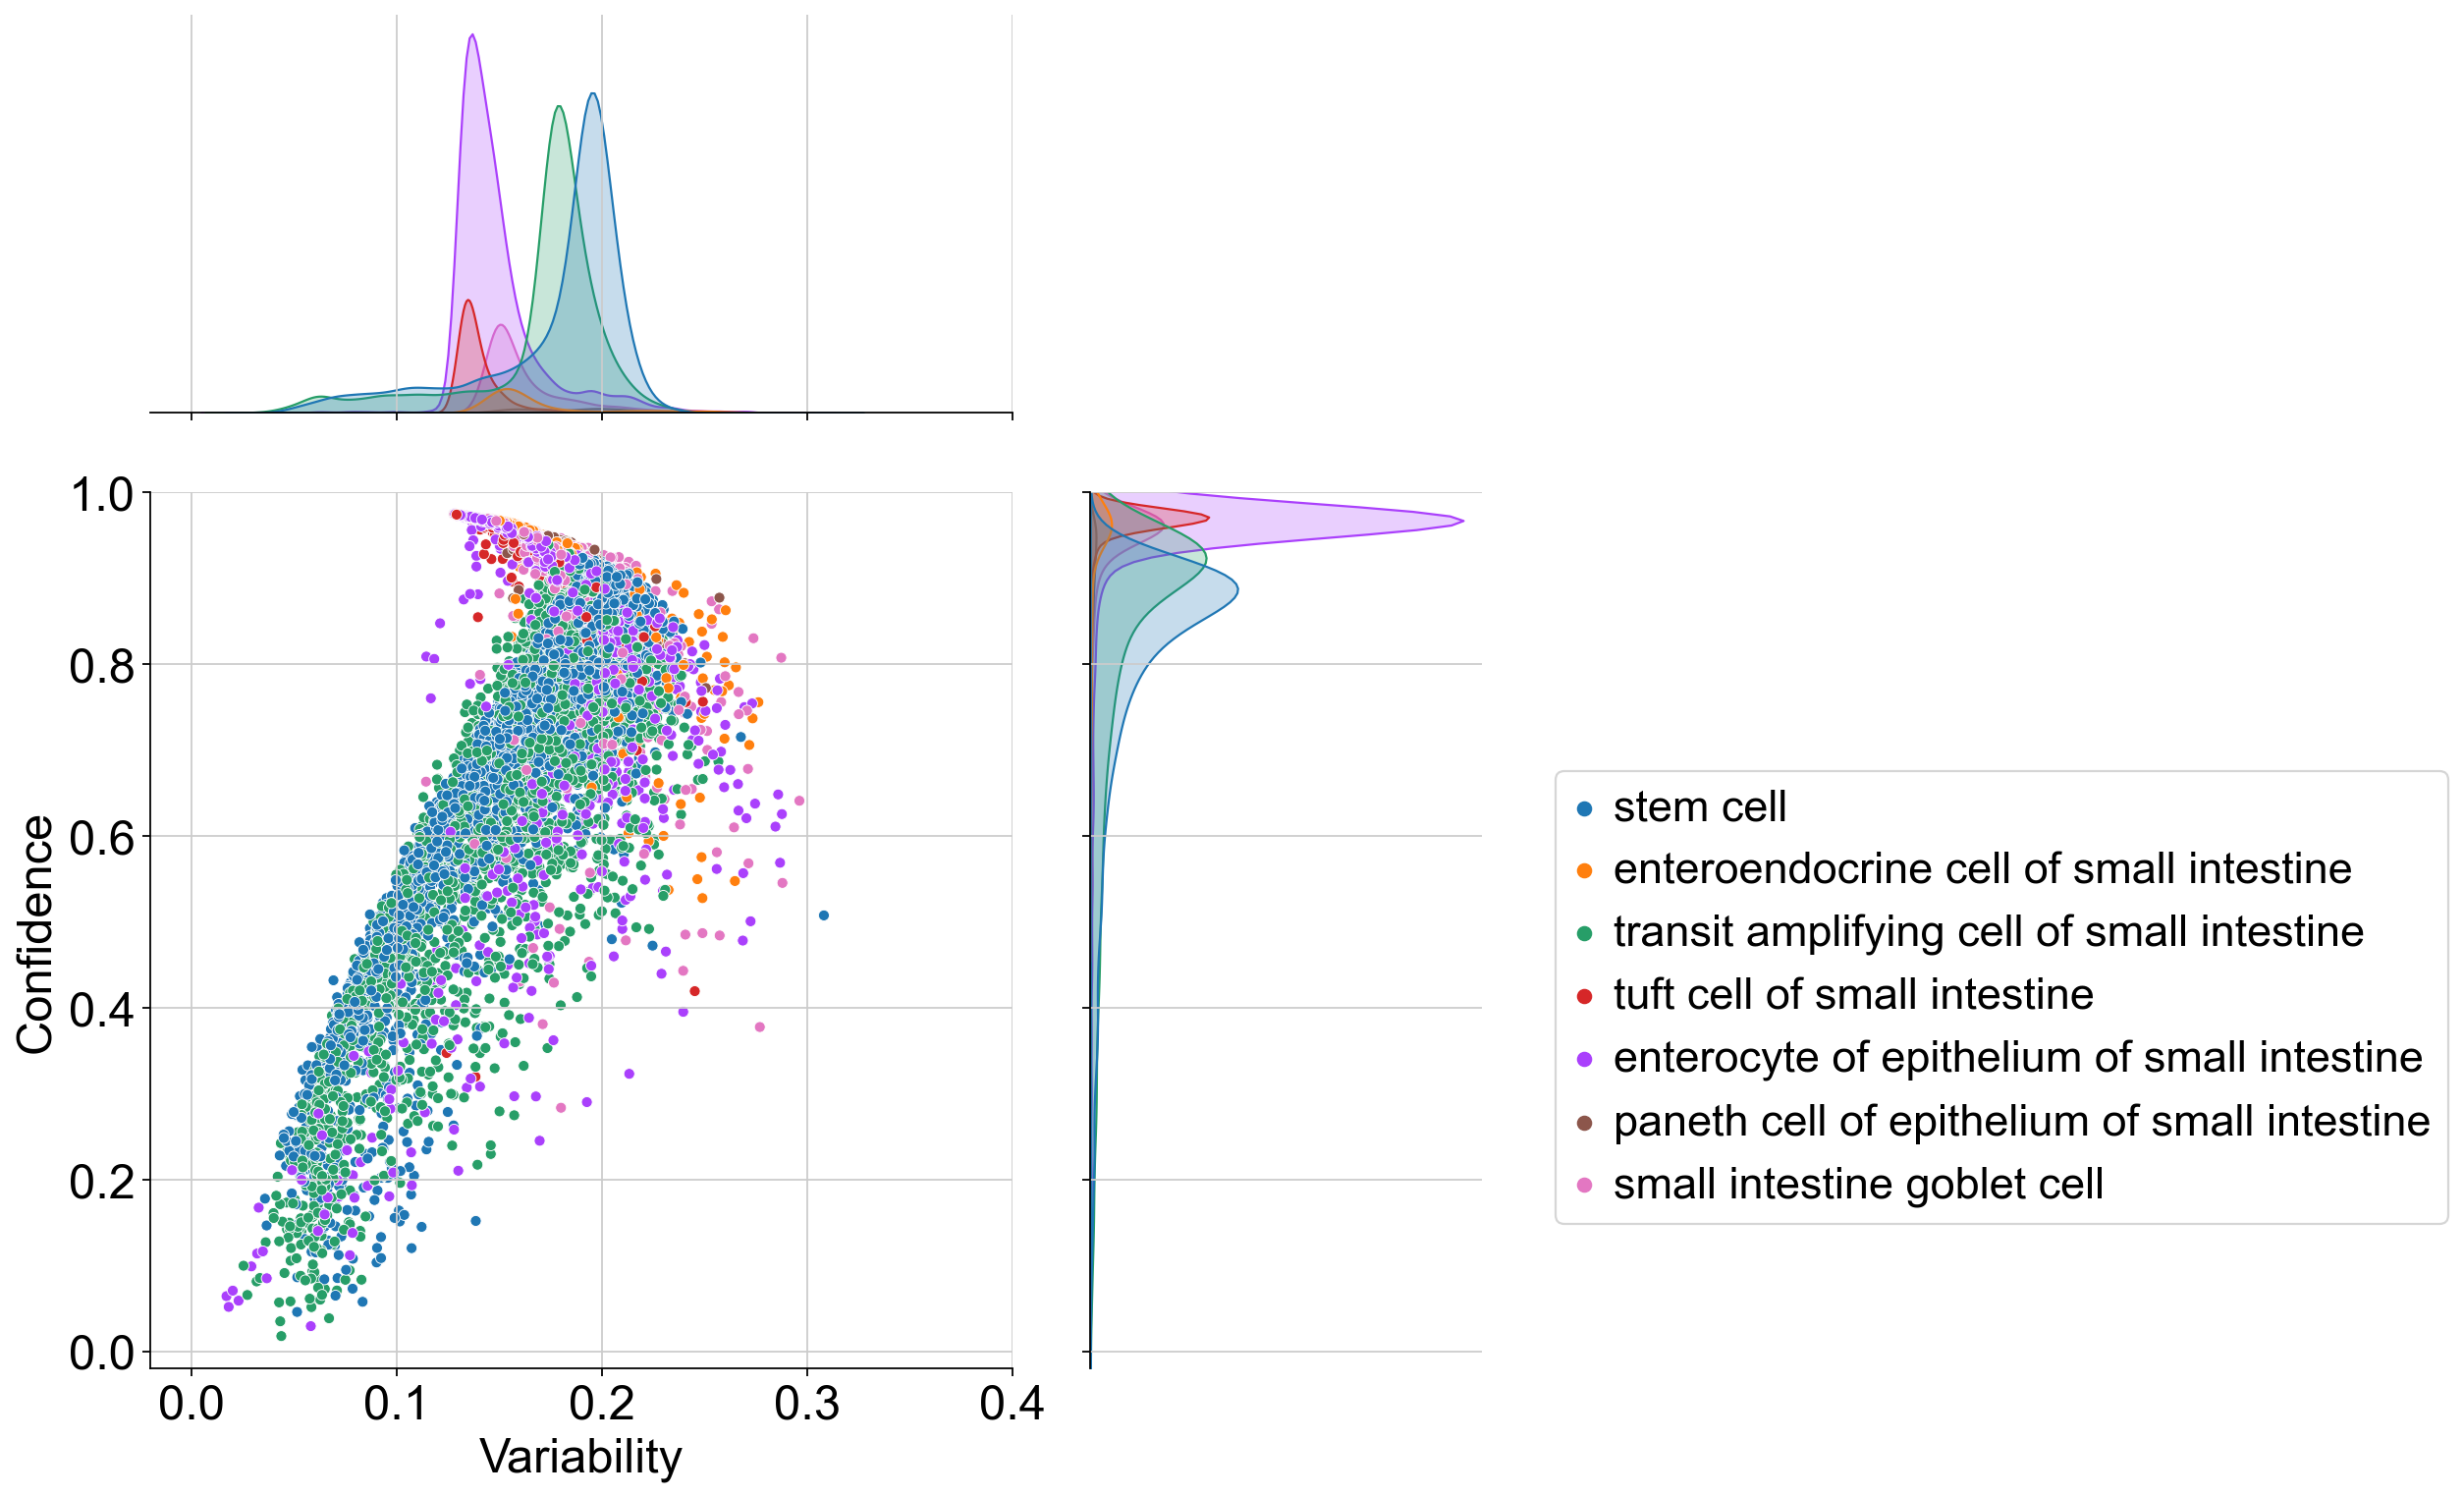

In [10]:
adata.obs['Confidence']= adata.obs['conf']
adata.obs['Variability']= adata.obs['var']

fig = sns.jointplot(data=adata.obs, x="Variability", y="Confidence",hue='cell_type',height=10,  s=25, ratio=2,
                    xlim=[-0.02,0.4], ylim=[-0.02,1])
fig.ax_joint.legend_.remove()
#fig.fig.subplots_adjust(top=0.9)  # Adjust top margin to make room for the legend
fig.fig.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show()


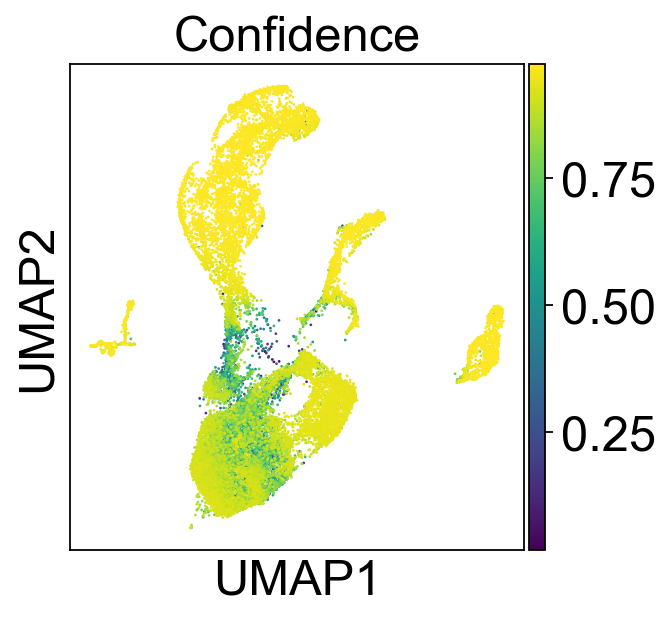

In [11]:
sc.pl.umap(adata, color=['conf'], title='Confidence')

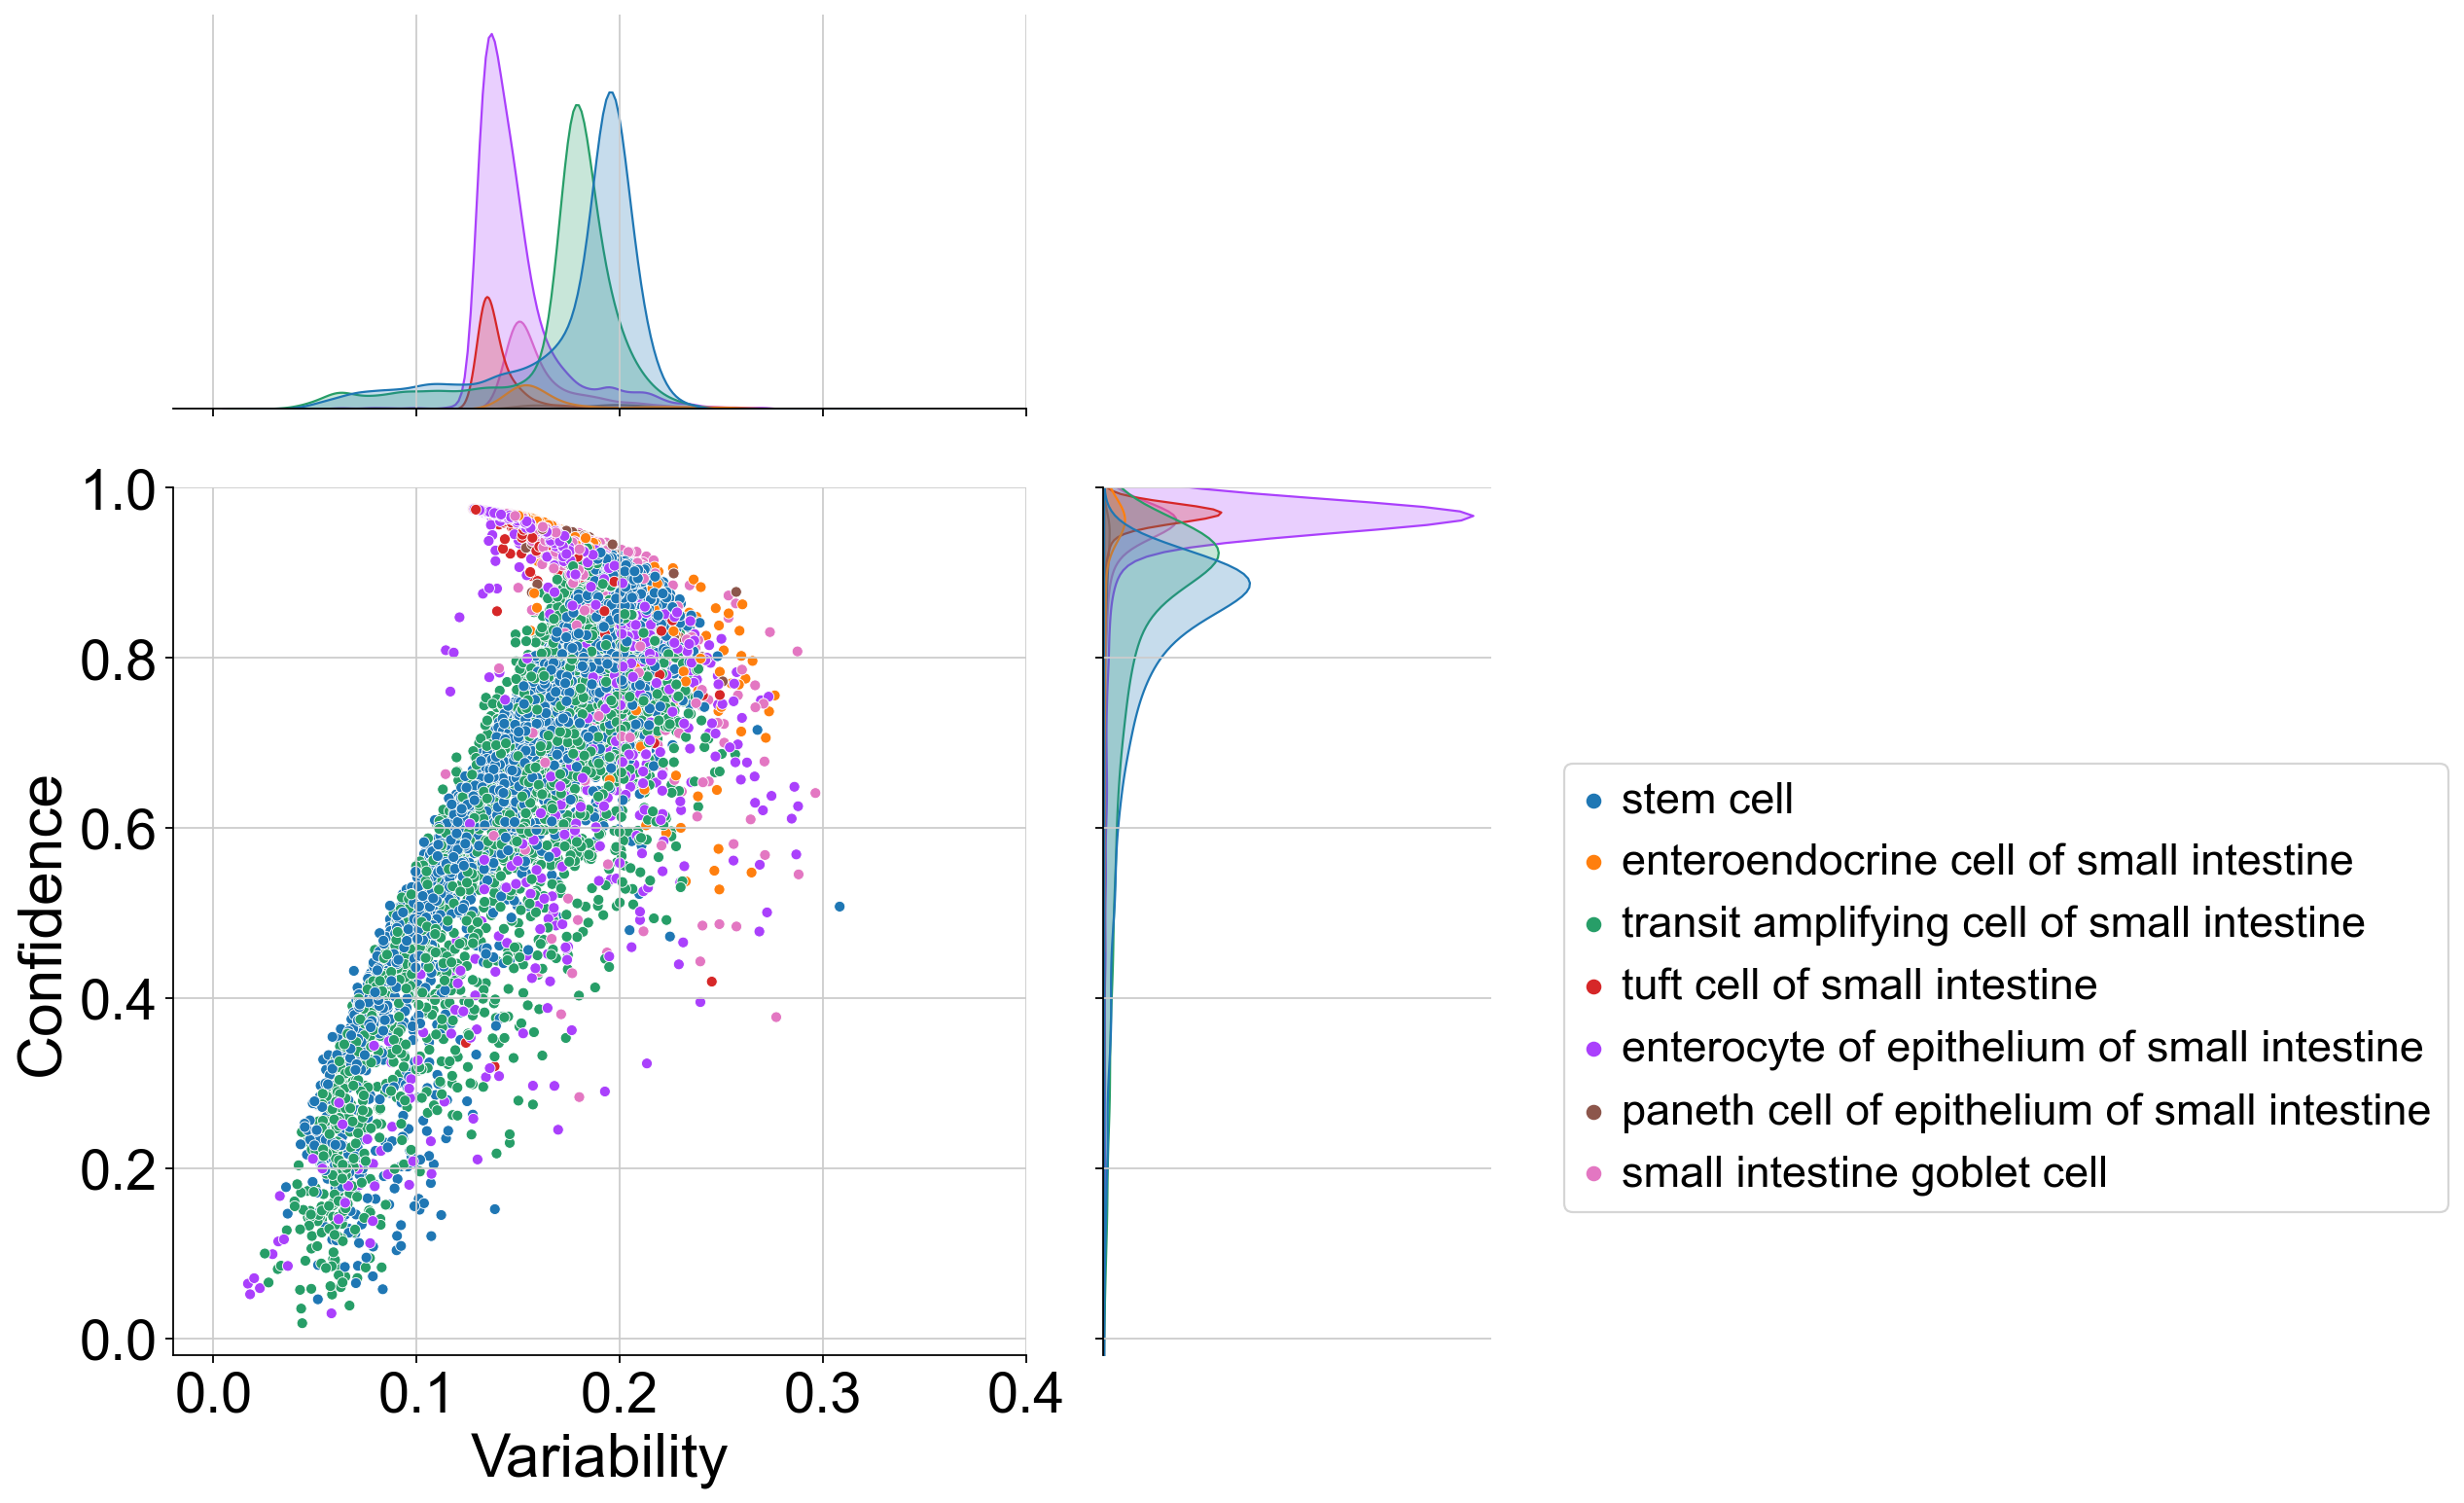

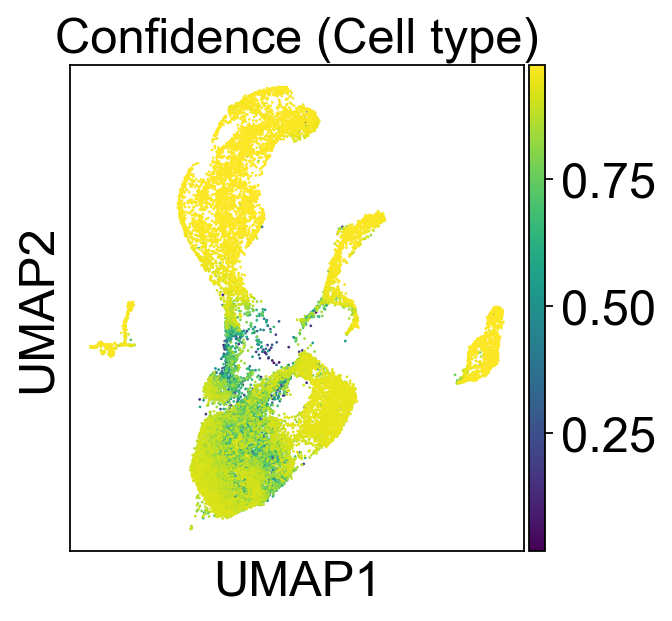

In [12]:
adata.obs['Confidence']= adata.obs['conf_celltype']
adata.obs['Variability']= adata.obs['var_celltype']

fig = sns.jointplot(data=adata.obs, x="Variability", y="Confidence",hue='cell_type',height=10,  s=25, ratio=2,
                    xlim=[-0.02,0.4], ylim=[-0.02,1])
fig.ax_joint.legend_.remove()
#fig.fig.subplots_adjust(top=0.9)  # Adjust top margin to make room for the legend
fig.fig.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
fig.ax_joint.tick_params(axis='x', labelsize=26)  # Increase x-axis tick labels
fig.ax_joint.tick_params(axis='y', labelsize=26)  # Increase y-axis tick labels if needed
fig.ax_joint.set_xlabel('Variability', fontsize=28)  # Set the desired fontsize

# Increase the y-axis label size if needed
fig.ax_joint.set_ylabel('Confidence', fontsize=28)  # Set the desired fontsize

plt.show()
sc.pl.umap(adata, color=['conf_celltype'], title='Confidence (Cell type)')

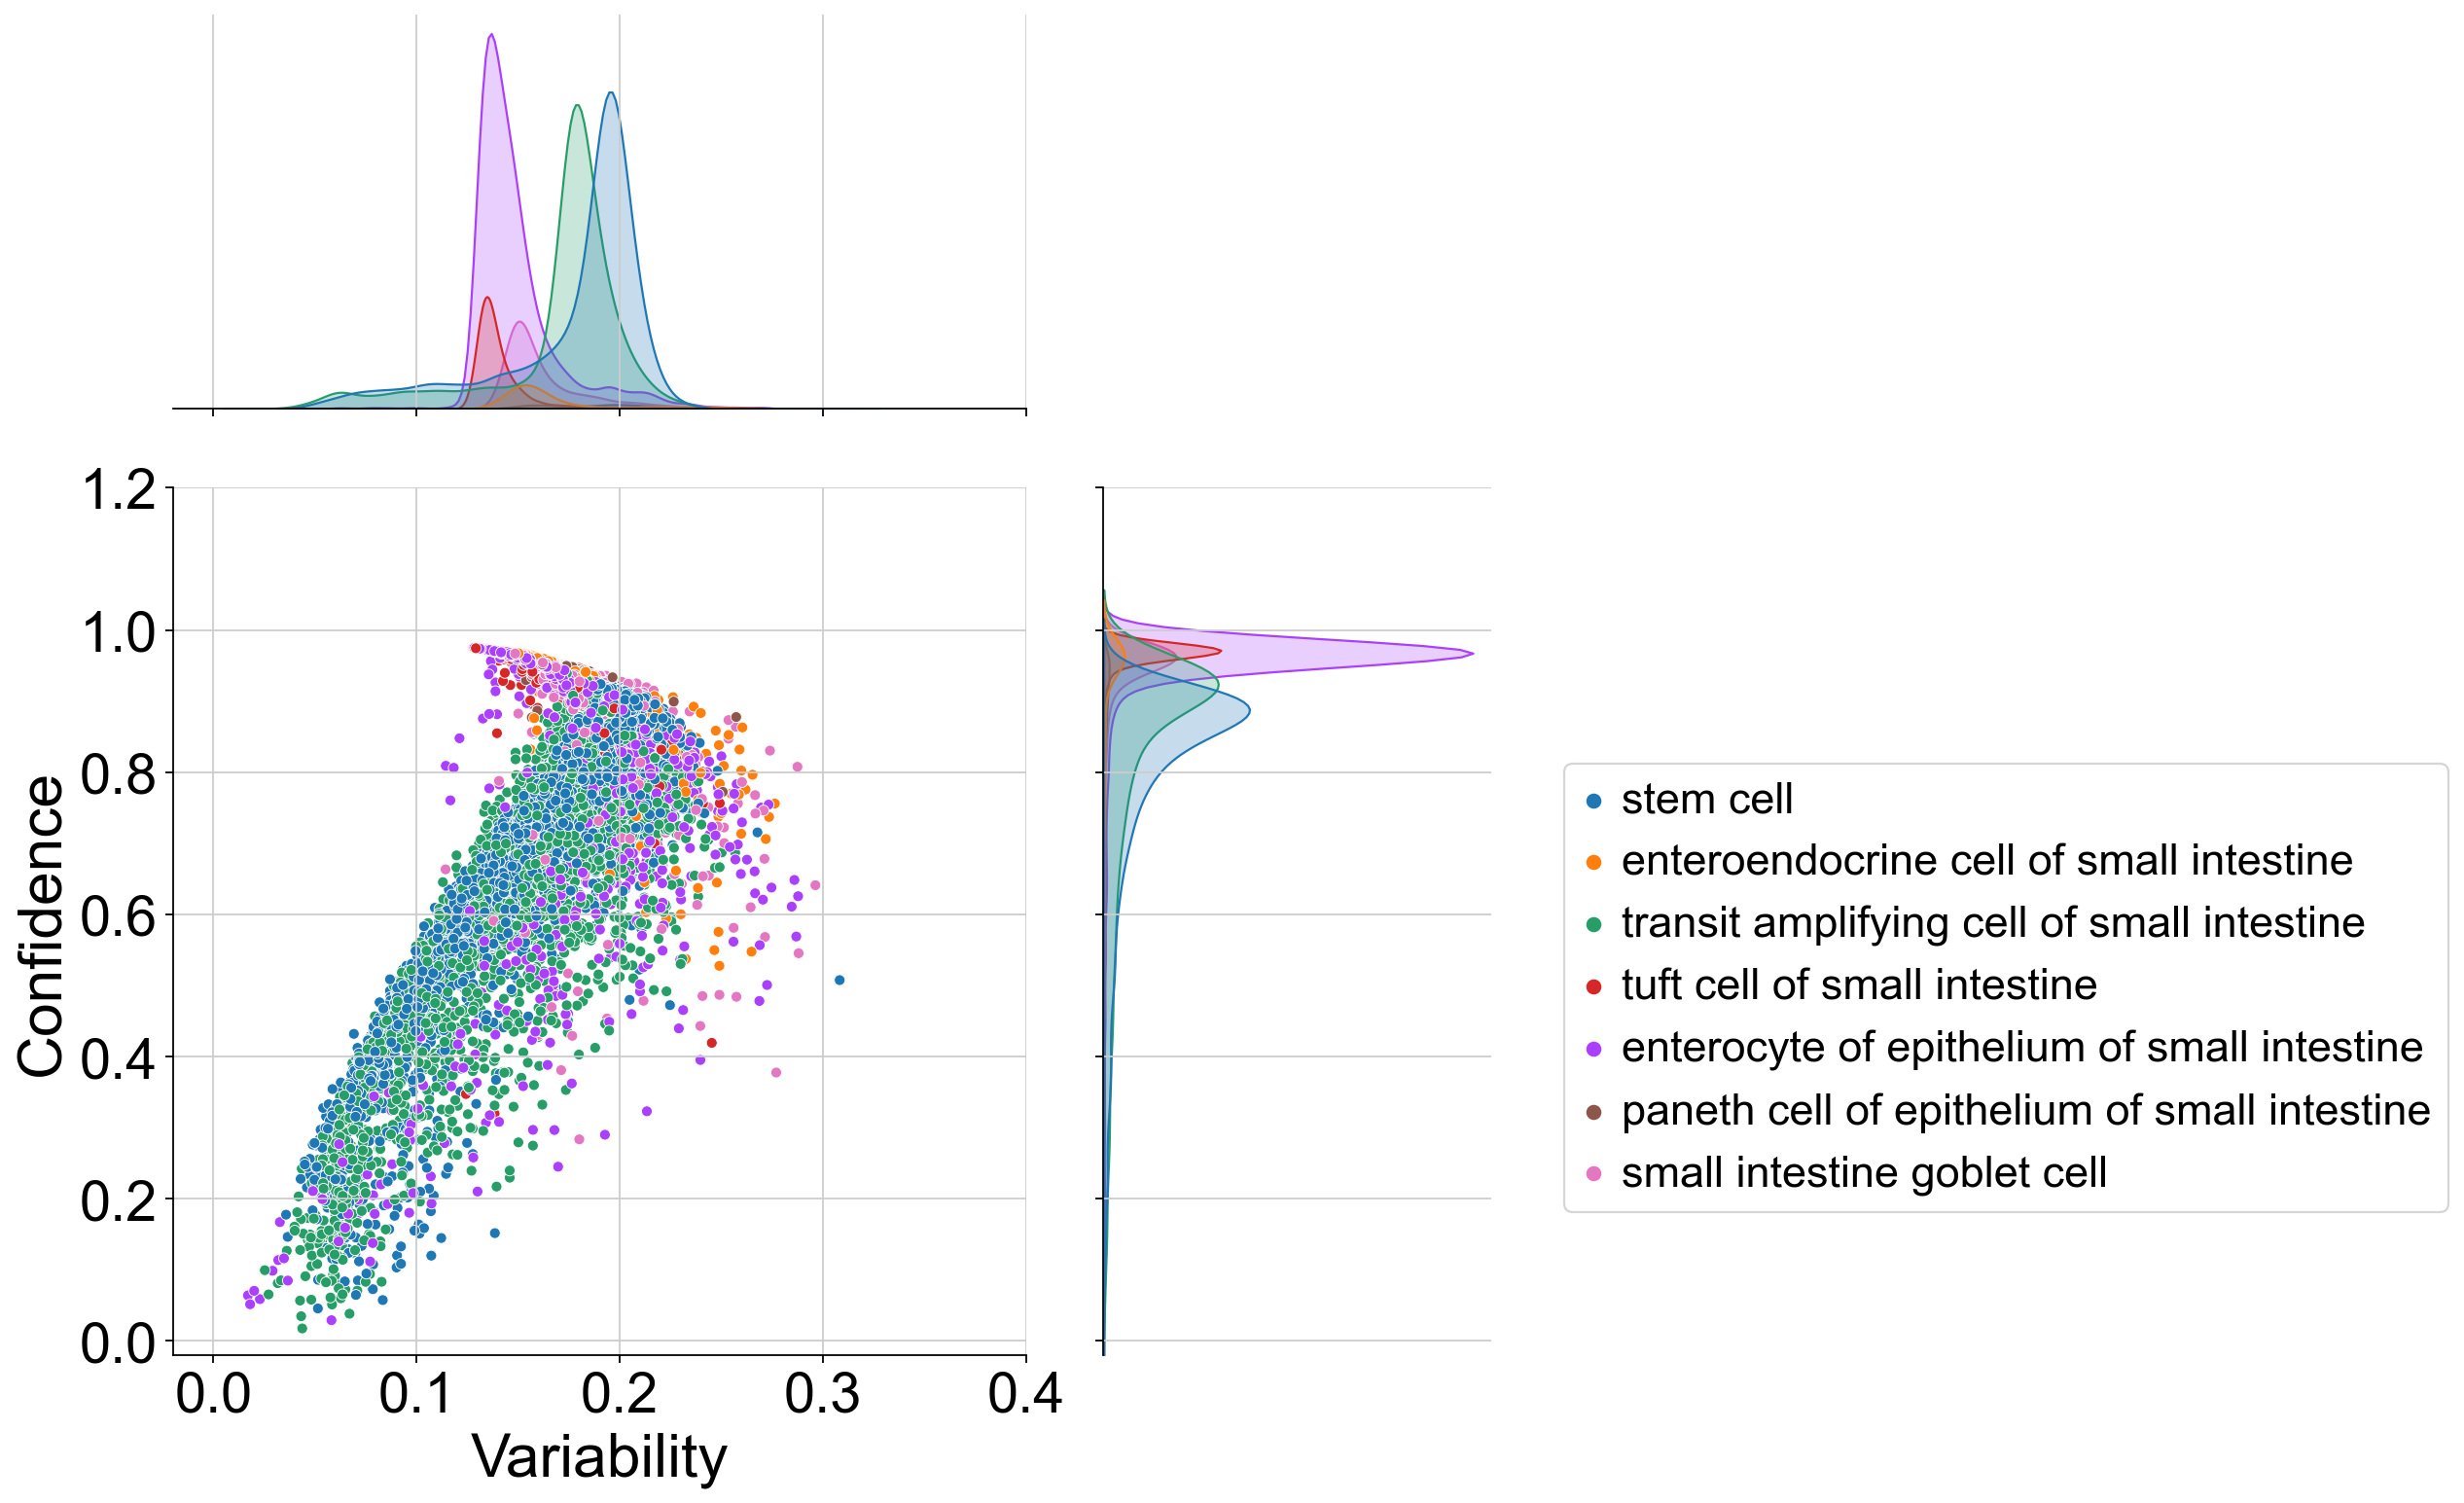

In [13]:
adata.obs['Confidence']= adata.obs['conf_celltype']
adata.obs['Variability']= adata.obs['var_celltype']

fig = sns.jointplot(data=adata.obs, x="Variability", y="Confidence",hue='cell_type',height=10,  s=25, ratio=2,
                    xlim=[-0.02,0.4], ylim=[-0.02,1.2])
fig.ax_joint.legend_.remove()
#fig.fig.subplots_adjust(top=0.9)  # Adjust top margin to make room for the legend
fig.fig.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
fig.ax_joint.tick_params(axis='x', labelsize=26)  # Increase x-axis tick labels
fig.ax_joint.tick_params(axis='y', labelsize=26)  # Increase y-axis tick labels if needed
fig.ax_joint.set_xlabel('Variability', fontsize=28)  # Set the desired fontsize

# Increase the y-axis label size if needed
fig.ax_joint.set_ylabel('Confidence', fontsize=28)  # Set the desired fontsize

plt.show()


In [14]:
epoch_num=50
prob_list = models.follow_training_dyn_neural_net(adata, label_key='segment domain',iterNum=epoch_num, device=device)

all_conf_segment , all_var_segment = models.probability_list_to_confidence_and_var(prob_list, n_obs= adata.n_obs, epoch_num=epoch_num)




[1,     2] loss: 0.323
[1,    12] loss: 1.611
[1,    22] loss: 1.606
[1,    32] loss: 1.599
[1,    42] loss: 1.595
[1,    52] loss: 1.589
[1,    62] loss: 1.582
[1,    72] loss: 1.574
[2,     2] loss: 0.314
[2,    12] loss: 1.565
[2,    22] loss: 1.556
[2,    32] loss: 1.545
[2,    42] loss: 1.536
[2,    52] loss: 1.529
[2,    62] loss: 1.515
[2,    72] loss: 1.503
[3,     2] loss: 0.299
[3,    12] loss: 1.479
[3,    22] loss: 1.461
[3,    32] loss: 1.445
[3,    42] loss: 1.430
[3,    52] loss: 1.406
[3,    62] loss: 1.377
[3,    72] loss: 1.370
[4,     2] loss: 0.264
[4,    12] loss: 1.309
[4,    22] loss: 1.292
[4,    32] loss: 1.272
[4,    42] loss: 1.243
[4,    52] loss: 1.205
[4,    62] loss: 1.205
[4,    72] loss: 1.166
[5,     2] loss: 0.225
[5,    12] loss: 1.127
[5,    22] loss: 1.103
[5,    32] loss: 1.079
[5,    42] loss: 1.052
[5,    52] loss: 1.019
[5,    62] loss: 1.018
[5,    72] loss: 1.005
[6,     2] loss: 0.199
[6,    12] loss: 0.970
[6,    22] loss: 0.959
[6,    32] 

[44,    12] loss: 0.314
[44,    22] loss: 0.352
[44,    32] loss: 0.324
[44,    42] loss: 0.334
[44,    52] loss: 0.317
[44,    62] loss: 0.315
[44,    72] loss: 0.344
[45,     2] loss: 0.076
[45,    12] loss: 0.309
[45,    22] loss: 0.316
[45,    32] loss: 0.314
[45,    42] loss: 0.323
[45,    52] loss: 0.330
[45,    62] loss: 0.332
[45,    72] loss: 0.327
[46,     2] loss: 0.069
[46,    12] loss: 0.307
[46,    22] loss: 0.322
[46,    32] loss: 0.340
[46,    42] loss: 0.353
[46,    52] loss: 0.305
[46,    62] loss: 0.336
[46,    72] loss: 0.304
[47,     2] loss: 0.050
[47,    12] loss: 0.296
[47,    22] loss: 0.320
[47,    32] loss: 0.322
[47,    42] loss: 0.320
[47,    52] loss: 0.299
[47,    62] loss: 0.309
[47,    72] loss: 0.332
[48,     2] loss: 0.068
[48,    12] loss: 0.312
[48,    22] loss: 0.303
[48,    32] loss: 0.323
[48,    42] loss: 0.313
[48,    52] loss: 0.309
[48,    62] loss: 0.313
[48,    72] loss: 0.304
[49,     2] loss: 0.063
[49,    12] loss: 0.326
[49,    22] loss

In [15]:

print(np.var(all_conf_segment.detach().numpy()))
print(np.var(all_var_segment.detach().numpy()))

0.03785065
0.0028854143


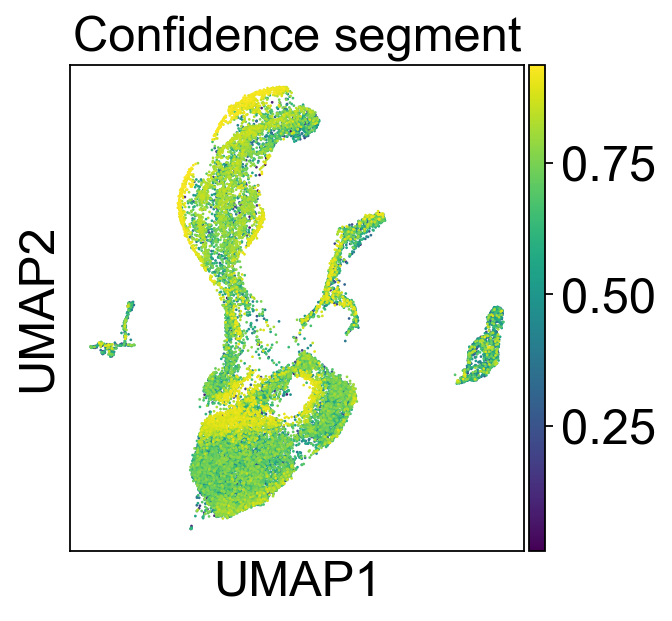

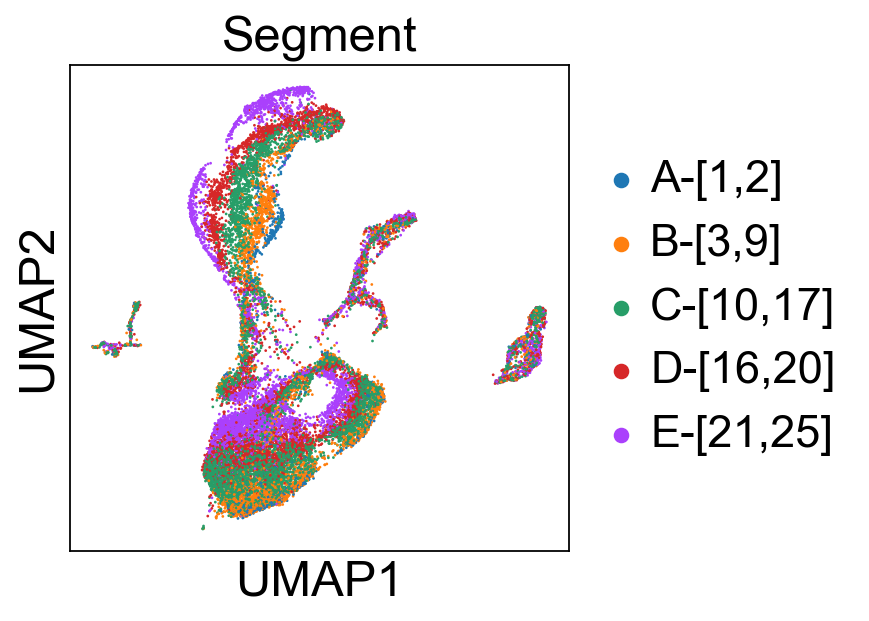

In [16]:
adata.obs["var_s"] = all_var_segment.detach().numpy()
adata.obs["conf_s"] = all_conf_segment.detach().numpy()

sc.pl.umap(adata, color=['conf_s'], title='Confidence segment')
sc.pl.umap(adata, color=['segment domain'], title='Segment')


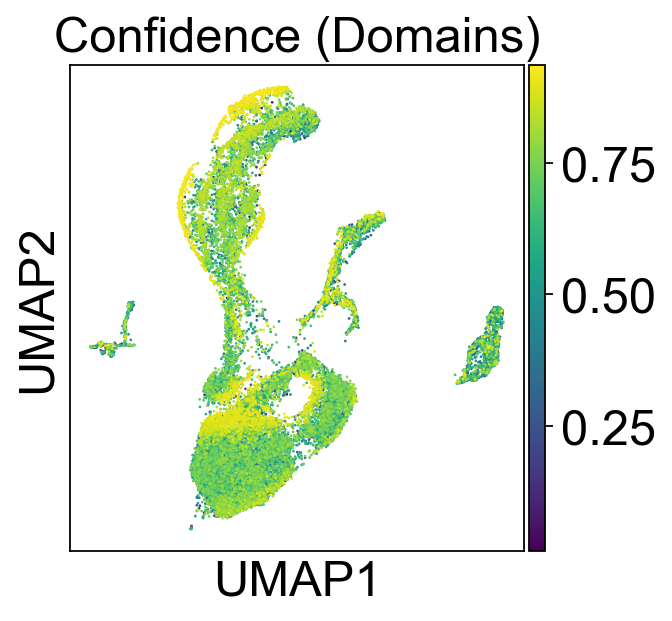

In [40]:
sc.pl.umap(adata, color=['conf_s'], title='Confidence (Domains)')


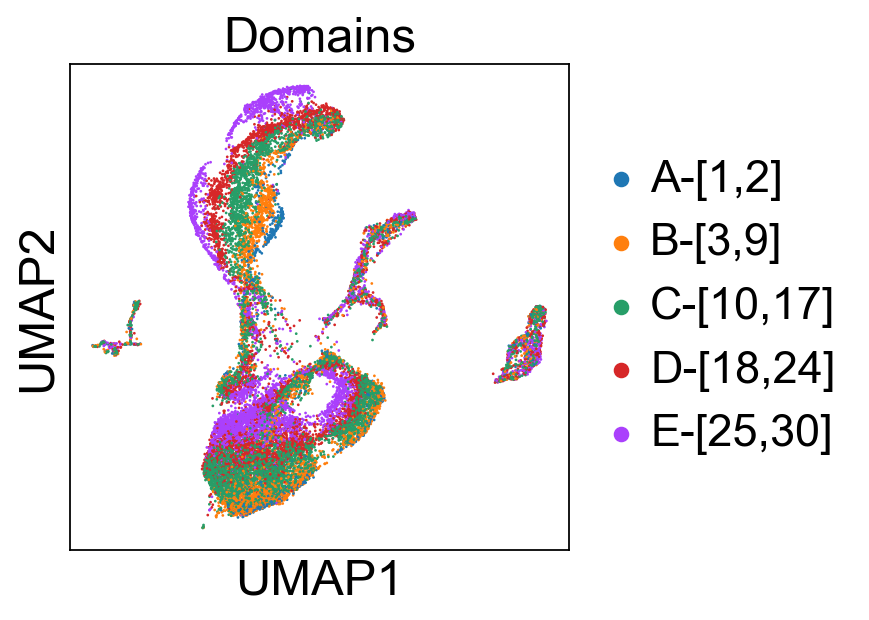

In [41]:
sc.pl.umap(adata, color=['segment domain'], title='Domains')


In [17]:
all_conf_segment

tensor([0.7520, 0.5718, 0.7812,  ..., 0.4444, 0.2856, 0.5070])

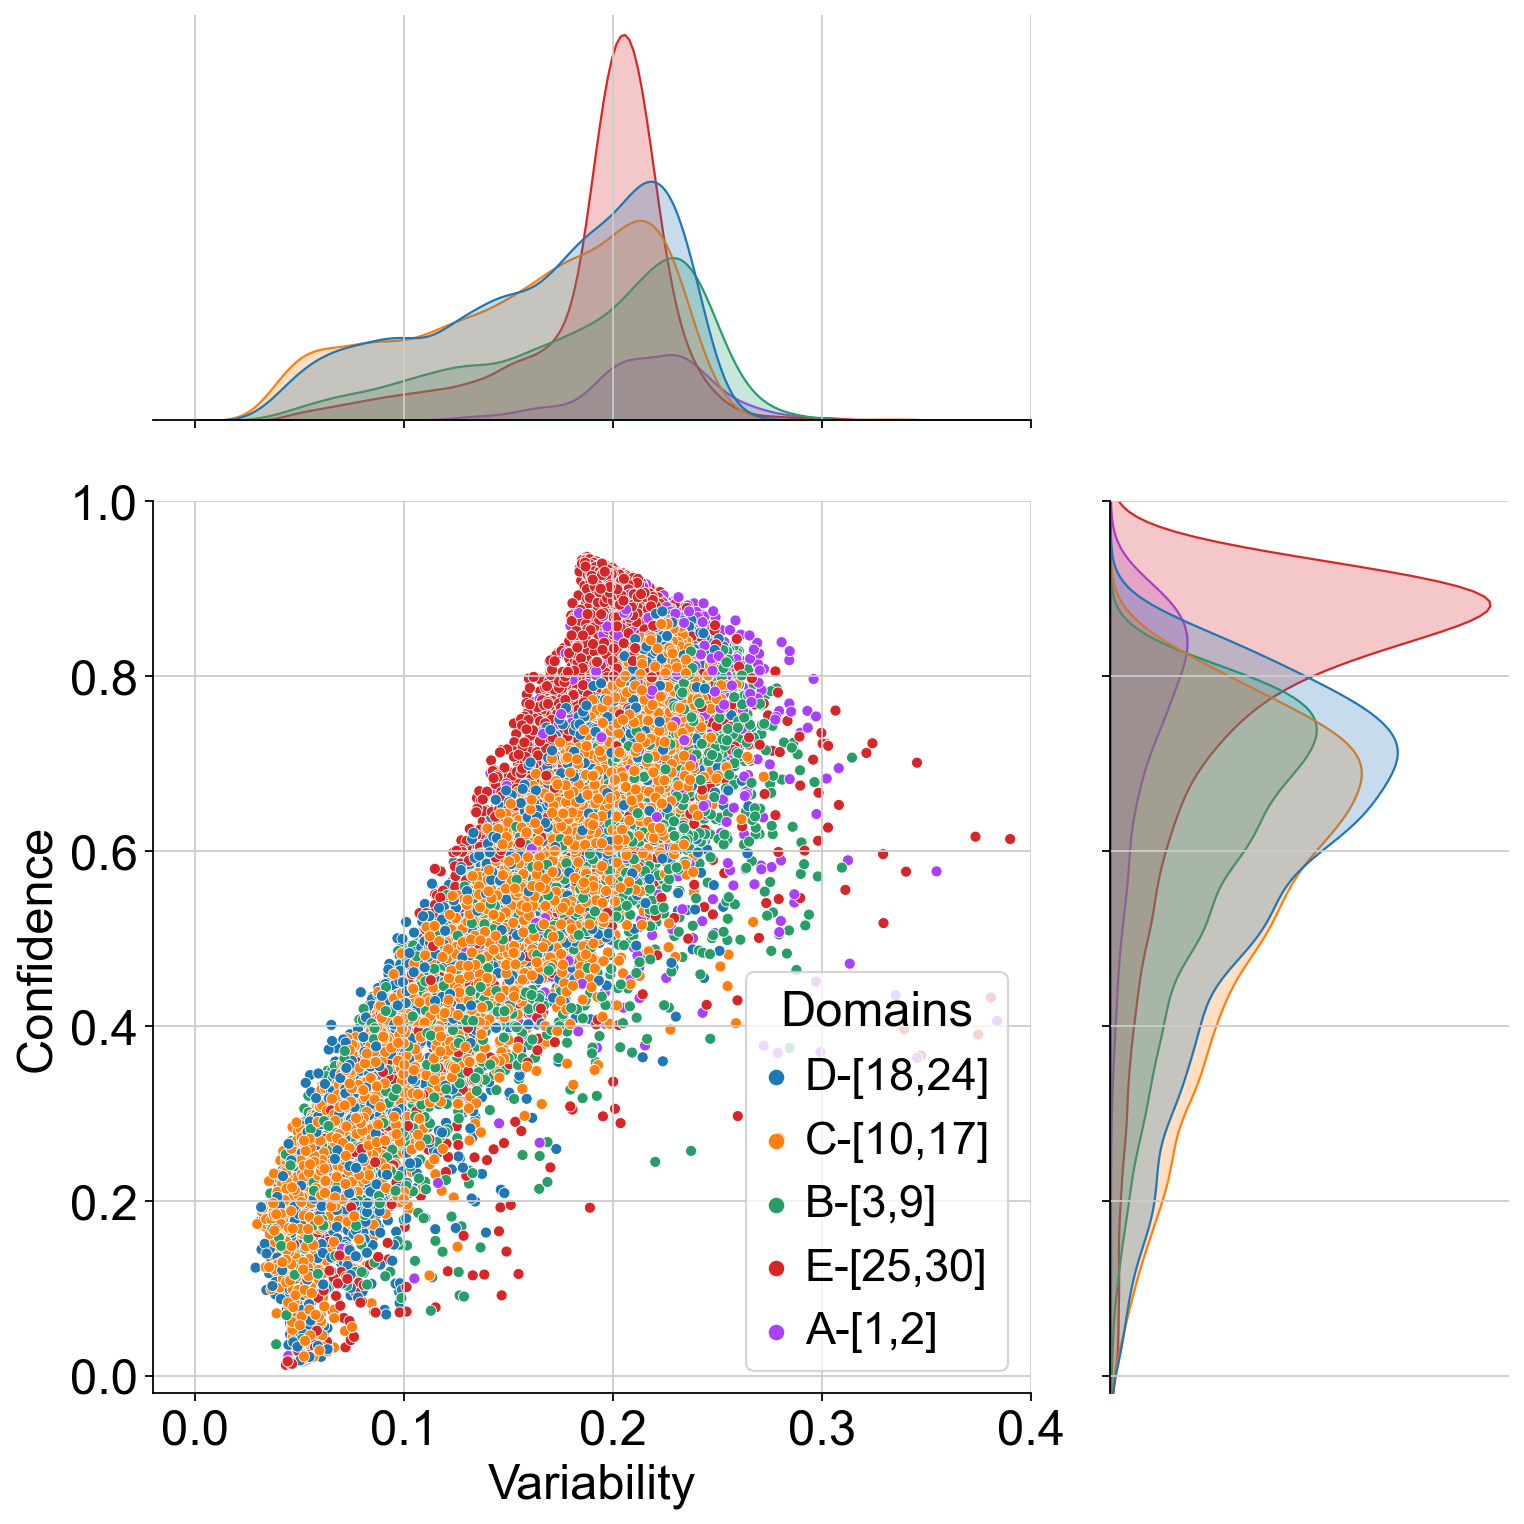

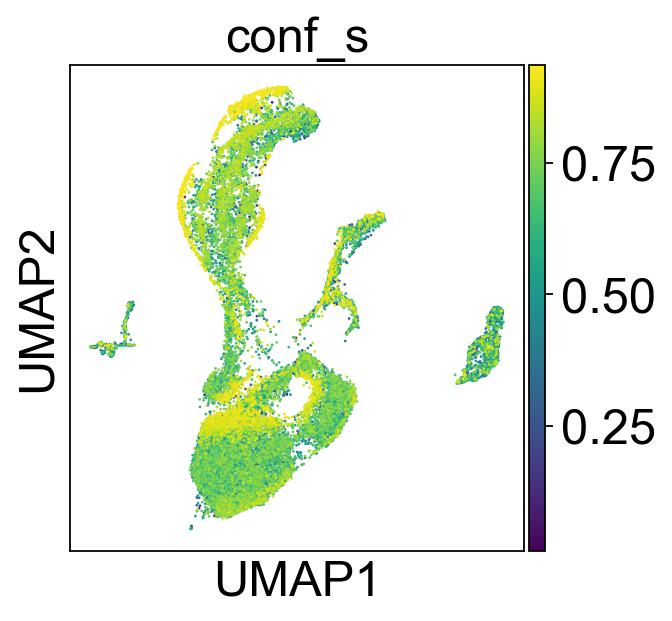

In [24]:
adata.obs["var_s"] = all_var_segment.detach().numpy()
adata.obs["conf_s"] = all_conf_segment.detach().numpy()
adata.obs['Confidence']= adata.obs['conf_s']
adata.obs['Variability']= adata.obs['var_s']
adata.obs['Domains']= adata.obs['segment domain']

fig = sns.jointplot(data=adata.obs, x="Variability", y="Confidence",hue='Domains',height=10,  s=25, ratio=2,
                    xlim=[-0.02,0.4], ylim=[-0.02,1])
sc.pl.umap(adata, color=['conf_s'])


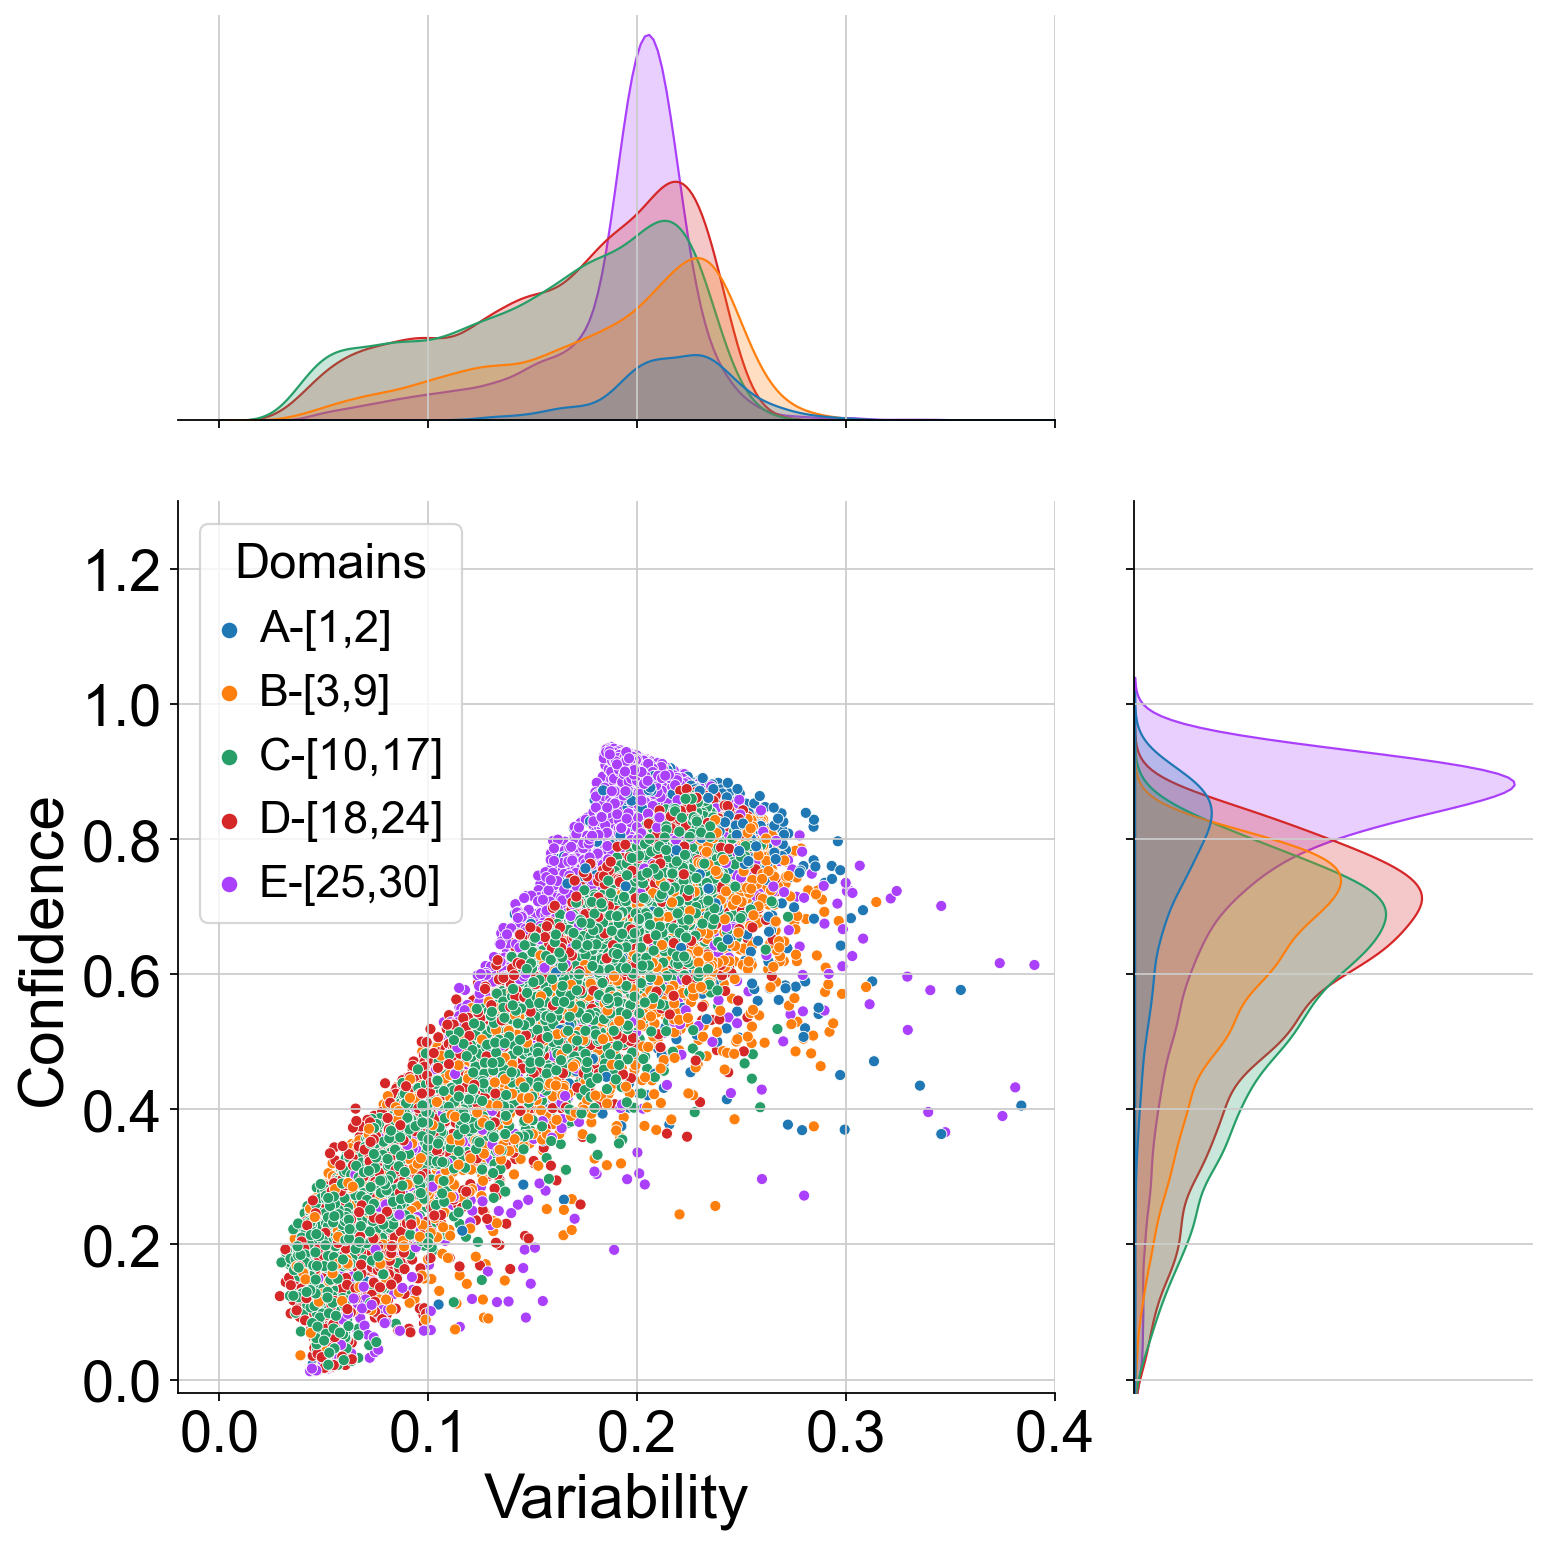

In [25]:

fig = sns.jointplot(data=adata.obs, x="Variability", y="Confidence",hue='Domains',height=10,  s=25, ratio=2,
                    xlim=[-0.02,0.4], ylim=[-0.02,1.3])

fig.ax_joint.tick_params(axis='x', labelsize=26)  # Increase x-axis tick labels
fig.ax_joint.tick_params(axis='y', labelsize=26)  # Increase y-axis tick labels if needed
fig.ax_joint.set_xlabel('Variability', fontsize=28)  # Set the desired fontsize

# Increase the y-axis label size if needed
fig.ax_joint.set_ylabel('Confidence', fontsize=28)  # Set the desired fontsize
plt.show()



In [26]:
epoch_num=50
prob_list = models.follow_training_dyn_neural_net(adata, label_key='Phase',iterNum=epoch_num, device=device)
all_conf_Phase , all_var_Phase = models.probability_list_to_confidence_and_var(prob_list, n_obs= adata.n_obs, epoch_num=epoch_num)

[1,     2] loss: 0.218
[1,    12] loss: 1.084
[1,    22] loss: 1.053
[1,    32] loss: 1.019
[1,    42] loss: 0.986
[1,    52] loss: 0.943
[1,    62] loss: 0.905
[1,    72] loss: 0.858
[2,     2] loss: 0.160
[2,    12] loss: 0.781
[2,    22] loss: 0.744
[2,    32] loss: 0.717
[2,    42] loss: 0.675
[2,    52] loss: 0.626
[2,    62] loss: 0.595
[2,    72] loss: 0.554
[3,     2] loss: 0.100
[3,    12] loss: 0.485
[3,    22] loss: 0.476
[3,    32] loss: 0.436
[3,    42] loss: 0.420
[3,    52] loss: 0.402
[3,    62] loss: 0.369
[3,    72] loss: 0.352
[4,     2] loss: 0.065
[4,    12] loss: 0.347
[4,    22] loss: 0.339
[4,    32] loss: 0.315
[4,    42] loss: 0.316
[4,    52] loss: 0.293
[4,    62] loss: 0.295
[4,    72] loss: 0.280
[5,     2] loss: 0.054
[5,    12] loss: 0.250
[5,    22] loss: 0.256
[5,    32] loss: 0.268
[5,    42] loss: 0.242
[5,    52] loss: 0.246
[5,    62] loss: 0.236
[5,    72] loss: 0.224
[6,     2] loss: 0.039
[6,    12] loss: 0.217
[6,    22] loss: 0.218
[6,    32] 

[44,    12] loss: 0.087
[44,    22] loss: 0.088
[44,    32] loss: 0.092
[44,    42] loss: 0.080
[44,    52] loss: 0.099
[44,    62] loss: 0.082
[44,    72] loss: 0.082
[45,     2] loss: 0.019
[45,    12] loss: 0.078
[45,    22] loss: 0.093
[45,    32] loss: 0.097
[45,    42] loss: 0.087
[45,    52] loss: 0.094
[45,    62] loss: 0.084
[45,    72] loss: 0.090
[46,     2] loss: 0.017
[46,    12] loss: 0.085
[46,    22] loss: 0.092
[46,    32] loss: 0.075
[46,    42] loss: 0.079
[46,    52] loss: 0.090
[46,    62] loss: 0.085
[46,    72] loss: 0.077
[47,     2] loss: 0.015
[47,    12] loss: 0.093
[47,    22] loss: 0.088
[47,    32] loss: 0.085
[47,    42] loss: 0.079
[47,    52] loss: 0.084
[47,    62] loss: 0.082
[47,    72] loss: 0.086
[48,     2] loss: 0.017
[48,    12] loss: 0.086
[48,    22] loss: 0.098
[48,    32] loss: 0.087
[48,    42] loss: 0.086
[48,    52] loss: 0.084
[48,    62] loss: 0.086
[48,    72] loss: 0.075
[49,     2] loss: 0.019
[49,    12] loss: 0.083
[49,    22] loss

In [27]:
print(np.var(all_var_Phase.detach().numpy()))
print(np.var(all_conf_Phase.detach().numpy()))

0.0011070973
0.03153719


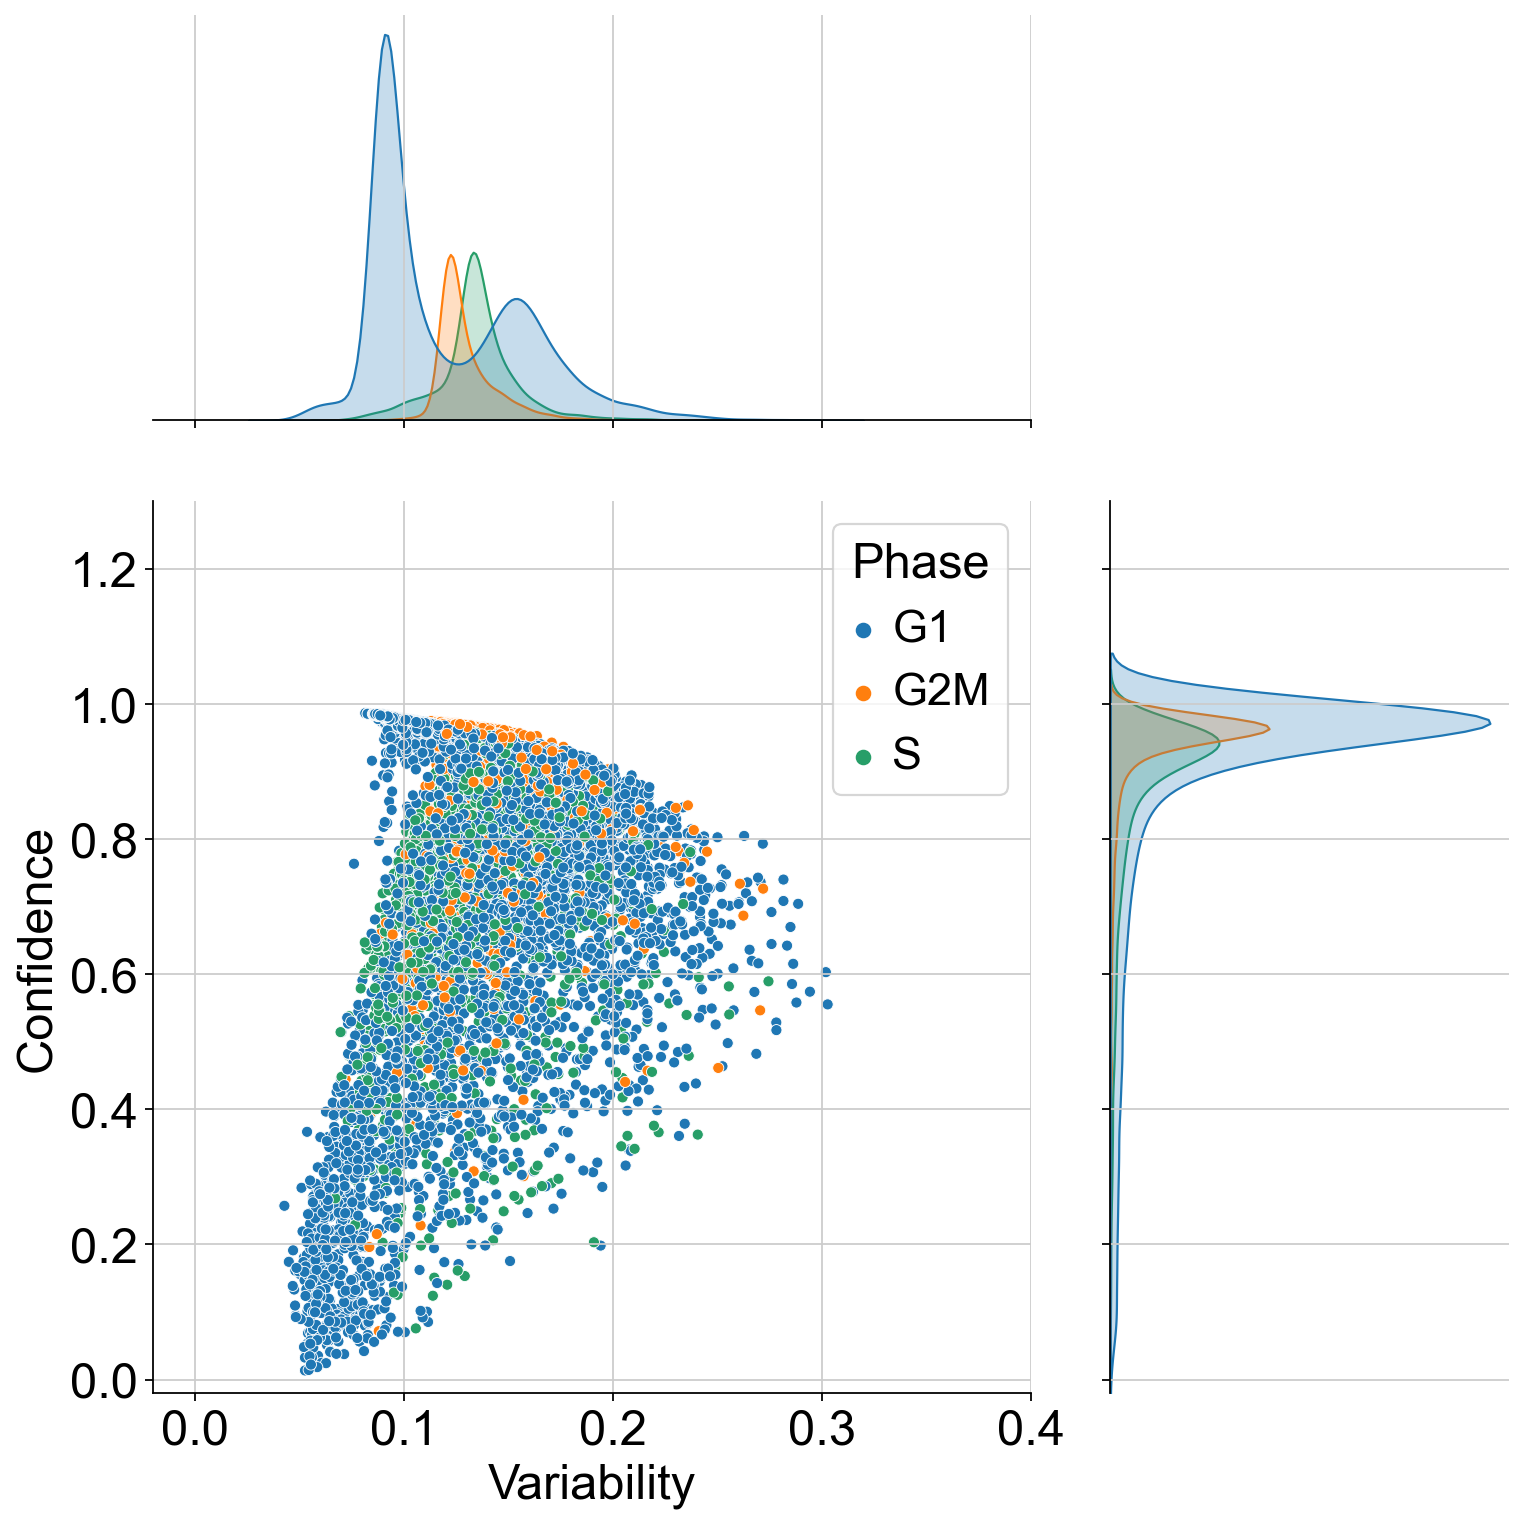

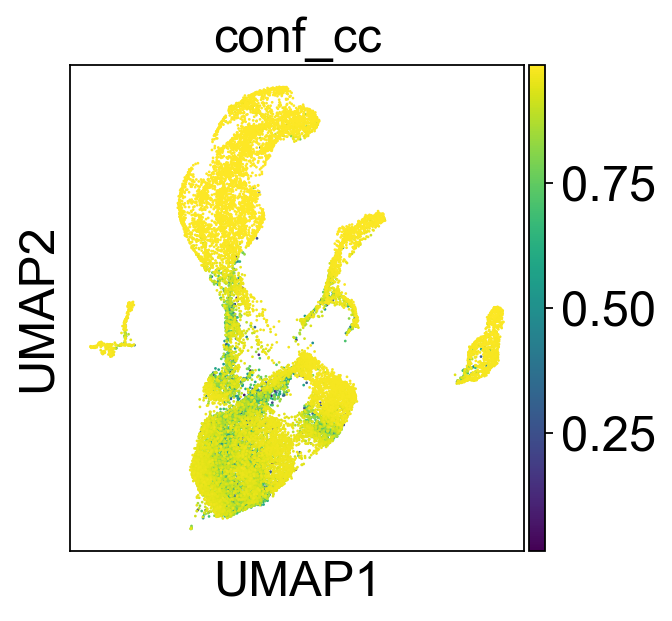

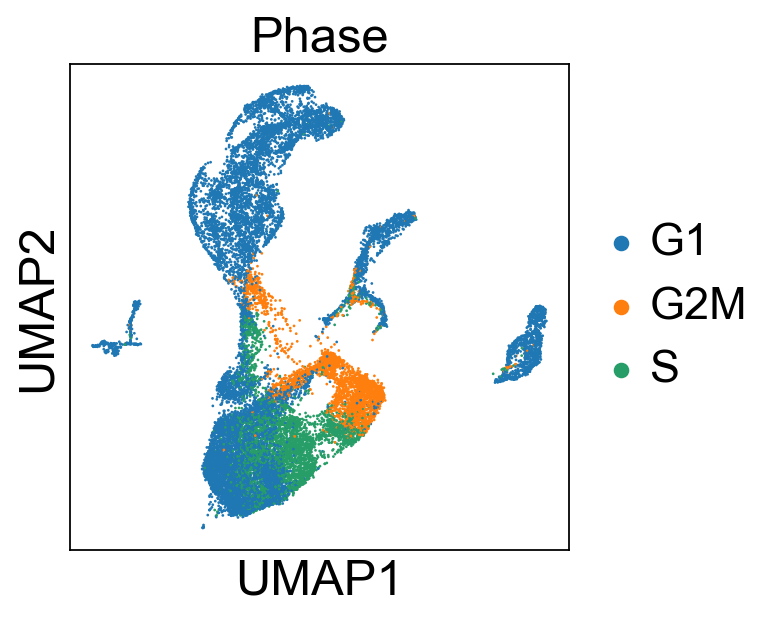

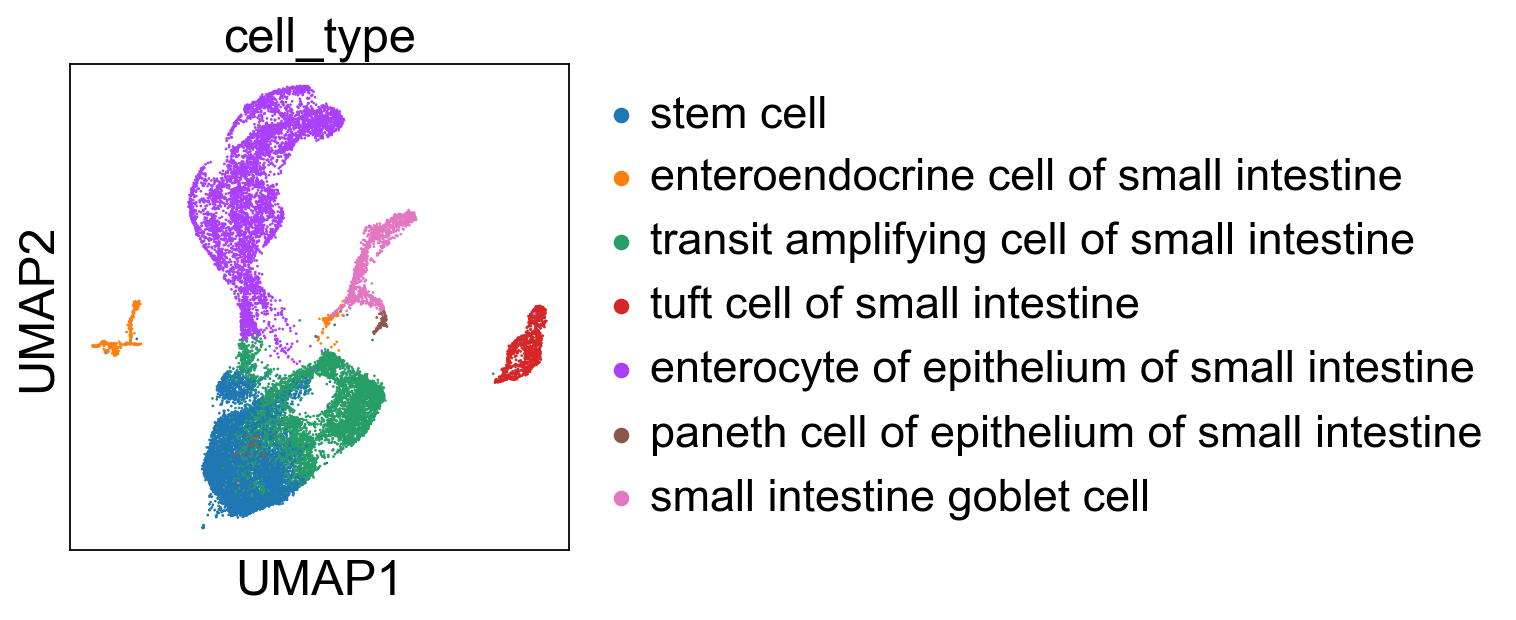

In [28]:
adata.obs["var_cc"] = all_var_Phase.detach().numpy()
adata.obs["conf_cc"] = all_conf_Phase.detach().numpy()
adata.obs['Confidence']= adata.obs['conf_cc']
adata.obs['Variability']= adata.obs['var_cc']

fig = sns.jointplot(data=adata.obs, x="Variability", y="Confidence",hue='Phase',height=10,  s=25, ratio=2,
                    xlim=[-0.02,0.4], ylim=[-0.02,1.3])
sc.pl.umap(adata, color=['conf_cc'])
sc.pl.umap(adata, color=['Phase'])
sc.pl.umap(adata, color=['cell_type'])


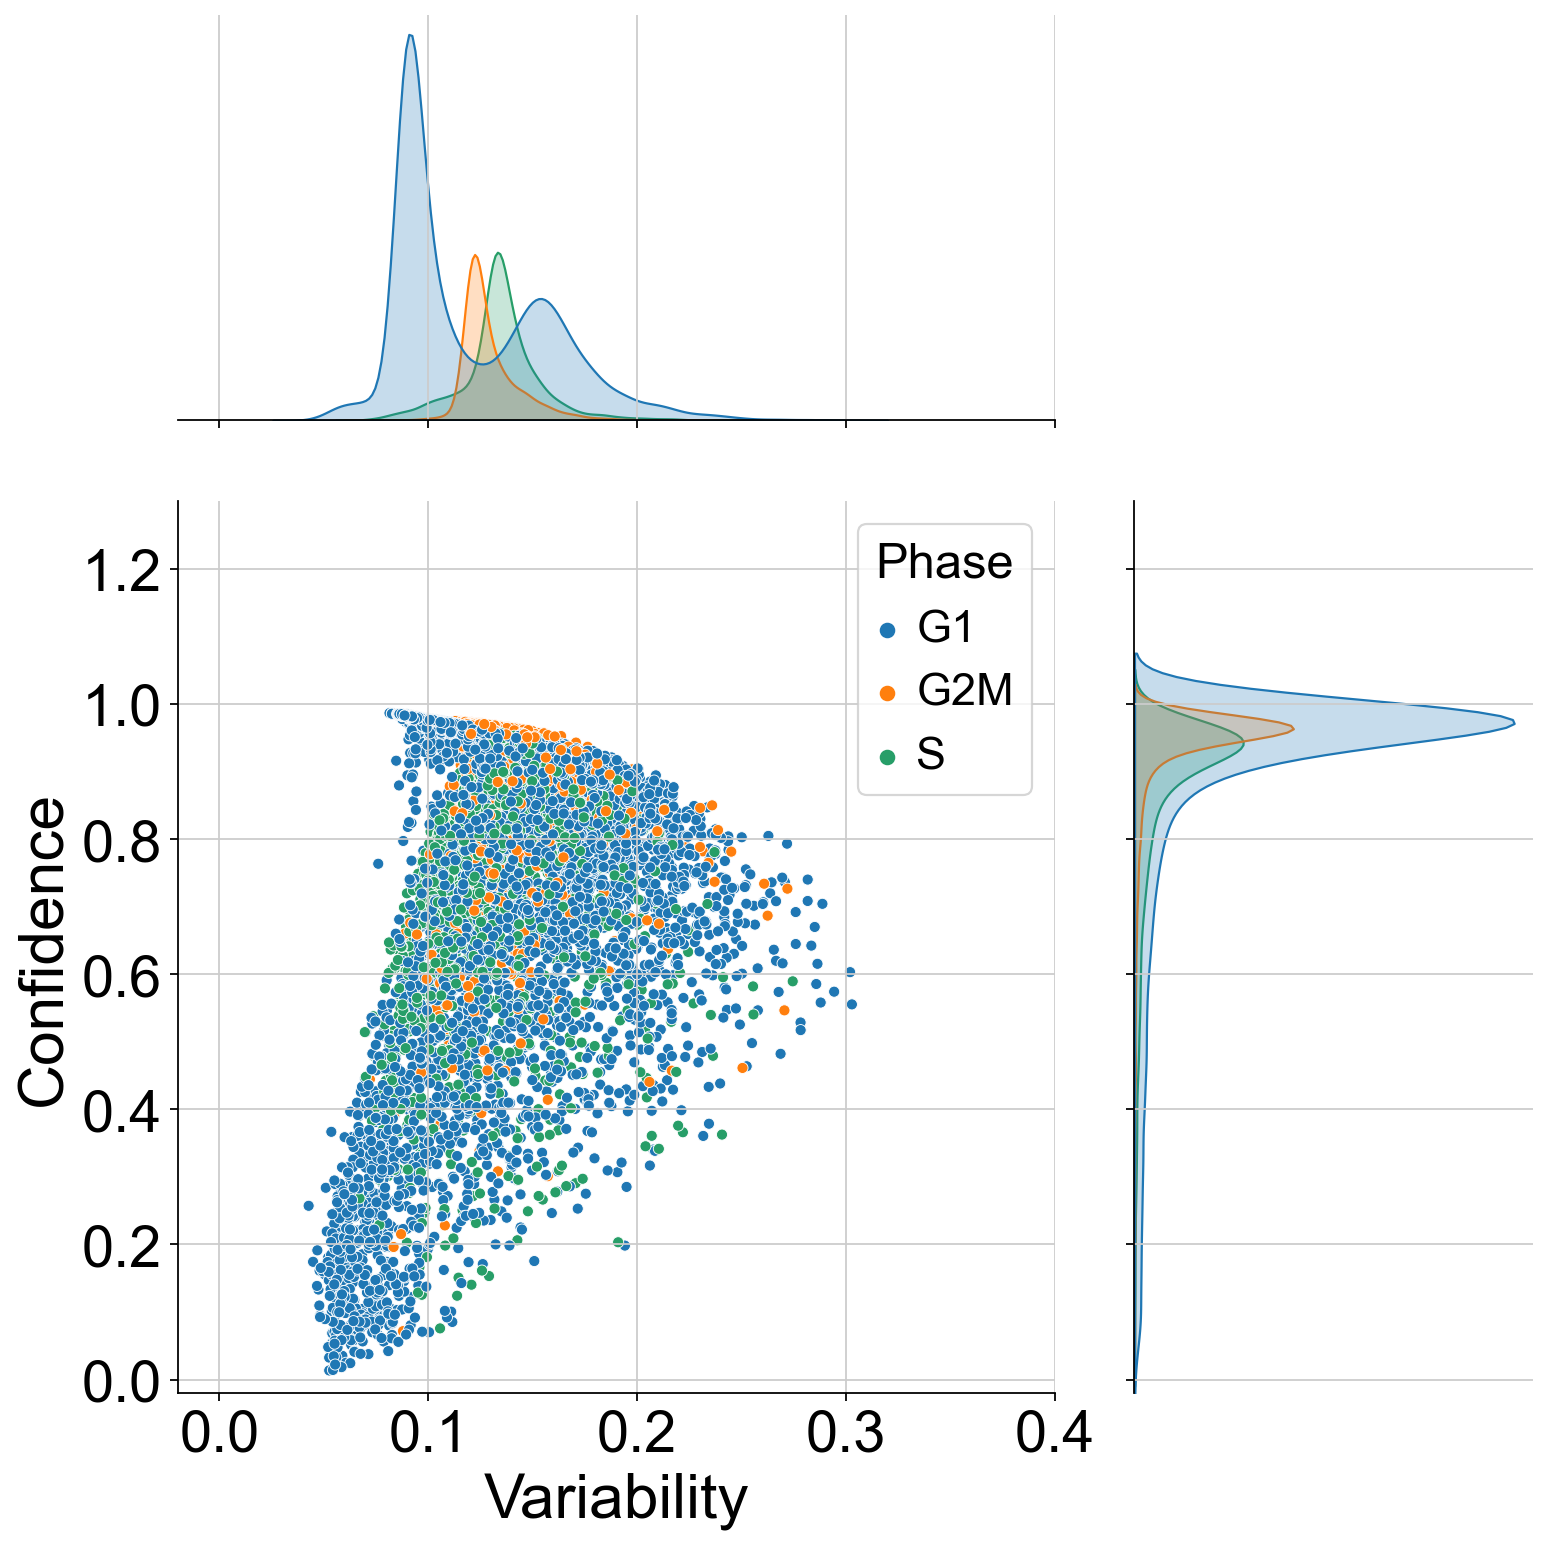

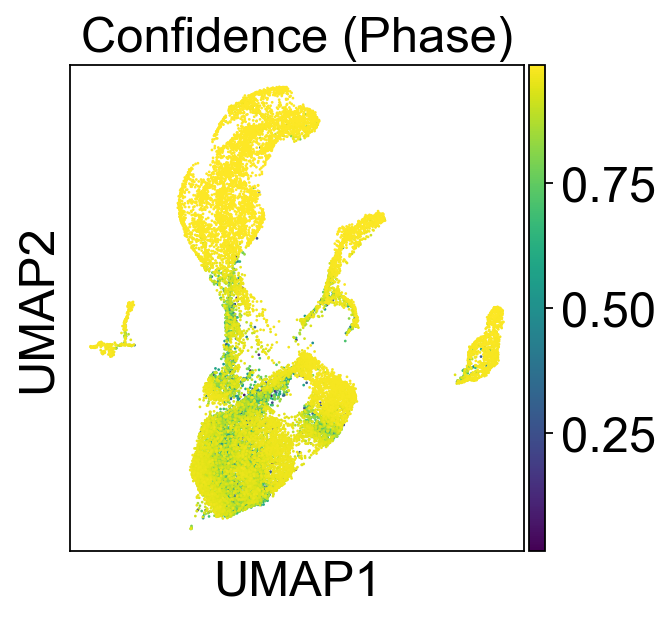

In [29]:
adata.obs['Confidence']= adata.obs['conf_cc']
adata.obs['Variability']= adata.obs['var_cc']

fig = sns.jointplot(data=adata.obs, x="Variability", y="Confidence",hue='Phase',height=10,  s=25, ratio=2,
                    xlim=[-0.02,0.4], ylim=[-0.02,1.3])

fig.ax_joint.tick_params(axis='x', labelsize=26)  # Increase x-axis tick labels
fig.ax_joint.tick_params(axis='y', labelsize=26)  # Increase y-axis tick labels if needed
fig.ax_joint.set_xlabel('Variability', fontsize=28)  # Set the desired fontsize

# Increase the y-axis label size if needed
fig.ax_joint.set_ylabel('Confidence', fontsize=28)  # Set the desired fontsize
plt.show()

sc.pl.umap(adata, color=['conf_cc'], title='Confidence (Phase)')


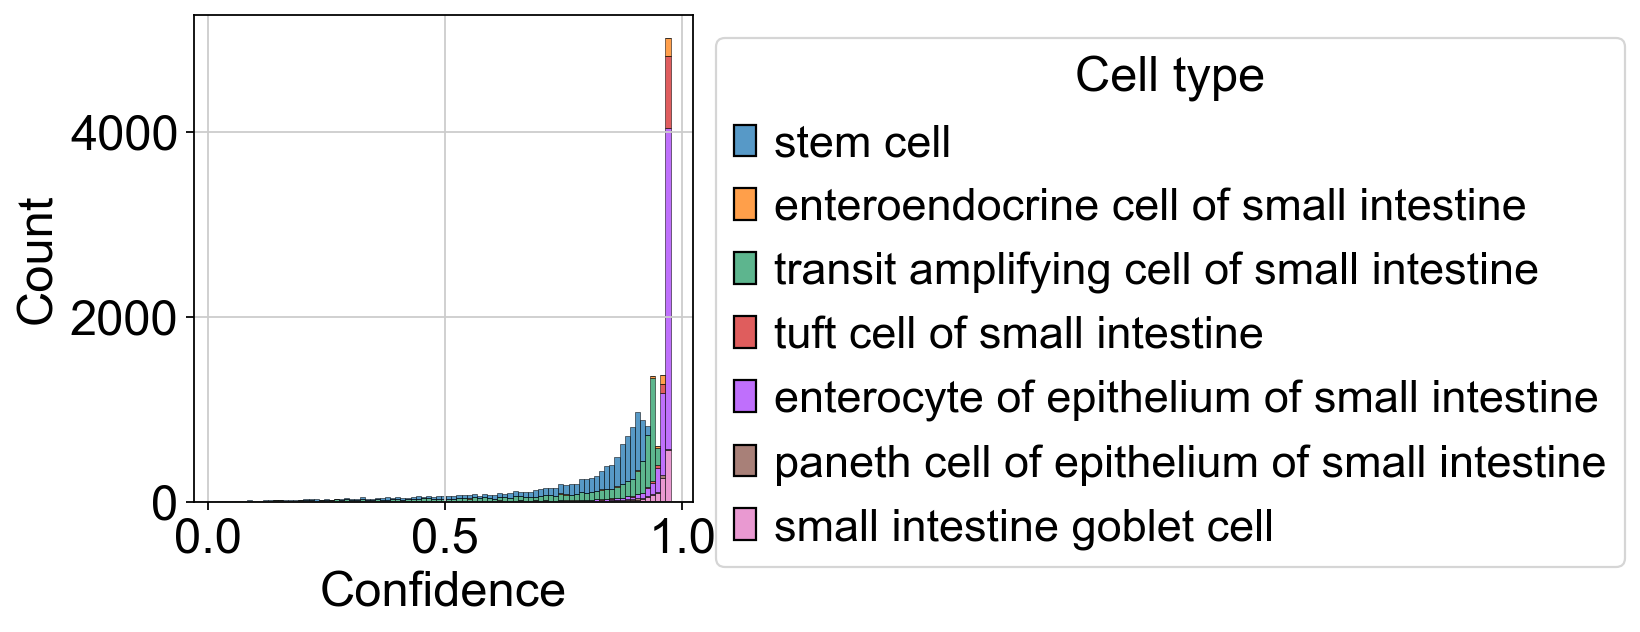

0.8490221
0.02888977


In [30]:
adata.obs['Confidence']=adata.obs['conf']
adata.obs['Cell type']=adata.obs['cell_type']
ax = sns.histplot(data=adata.obs, x="Confidence", hue="Cell type", multiple="stack")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()
#ax = sns.histplot(data=adata.obs, x="Confidence", hue="Cell type", multiple="layer")
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
print(np.mean(np.array(adata.obs['conf'])))
print(np.var(np.array(adata.obs['conf'])))

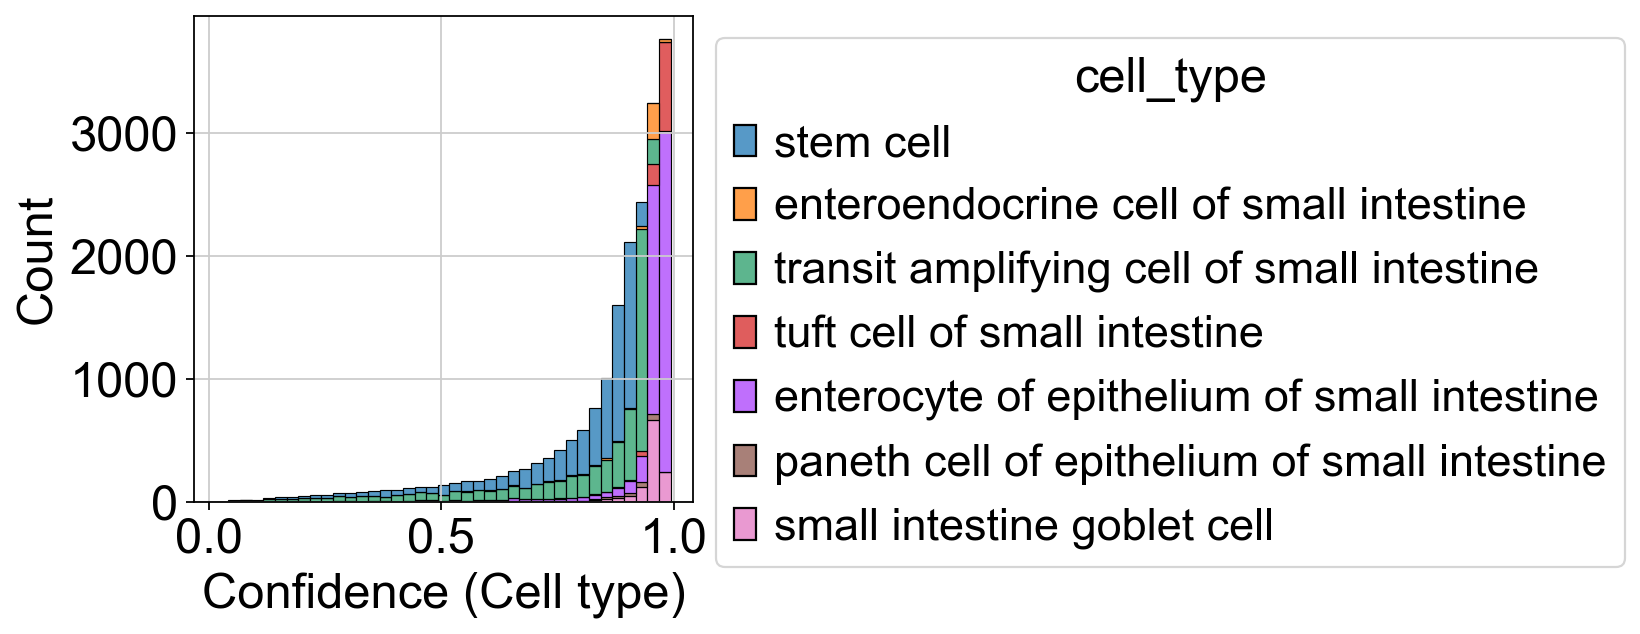

In [31]:
adata.obs['Confidence (Cell type)']=adata.obs['conf']

ax = sns.histplot(data=adata.obs, x="Confidence (Cell type)", hue="cell_type", multiple="stack", binwidth=0.025)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()


In [32]:
print(np.mean(np.array(adata.obs['conf'])))
print(np.var(np.array(adata.obs['conf'])))
print(np.mean(np.array(adata.obs['var'])))
print(np.var(np.array(adata.obs['var'])))

0.8490221
0.02888977
0.16457029
0.0011367801


In [33]:
print(np.mean(np.array(adata.obs['conf_cc'])))
print(np.var(np.array(adata.obs['conf_cc'])))
print(np.mean(np.array(adata.obs['var_cc'])))
print(np.var(np.array(adata.obs['var_cc'])))

0.8773271
0.03153719
0.1252389
0.0011070973


In [34]:
print(np.mean(np.array(adata.obs['conf_s'])))
print(np.var(np.array(adata.obs['conf_s'])))
print(np.mean(np.array(adata.obs['var_s'])))
print(np.var(np.array(adata.obs['var_s'])))

0.6308684
0.03785065
0.17732956
0.0028854143


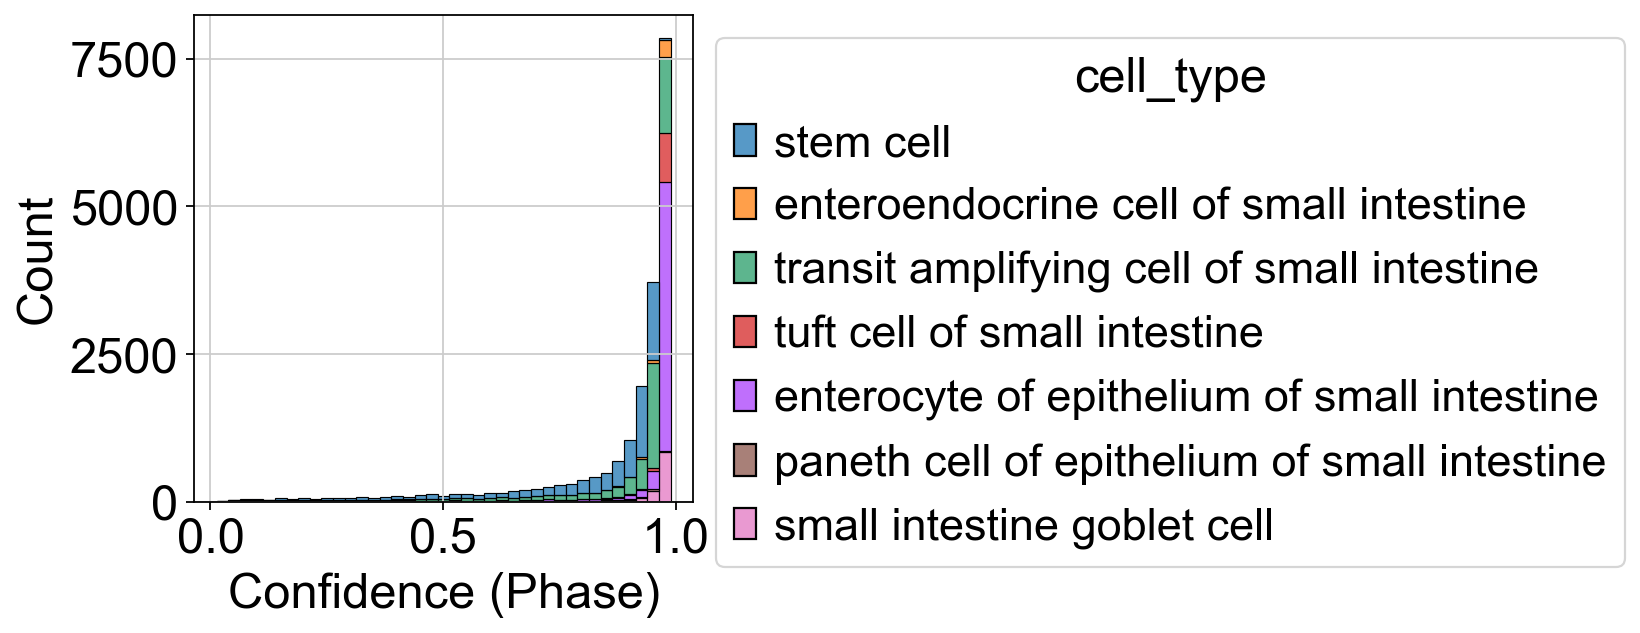

In [35]:
adata.obs['Confidence (Phase)']=adata.obs['conf_cc']

ax = sns.histplot(data=adata.obs, x="Confidence (Phase)", hue="cell_type", multiple="stack", binwidth=0.025)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()


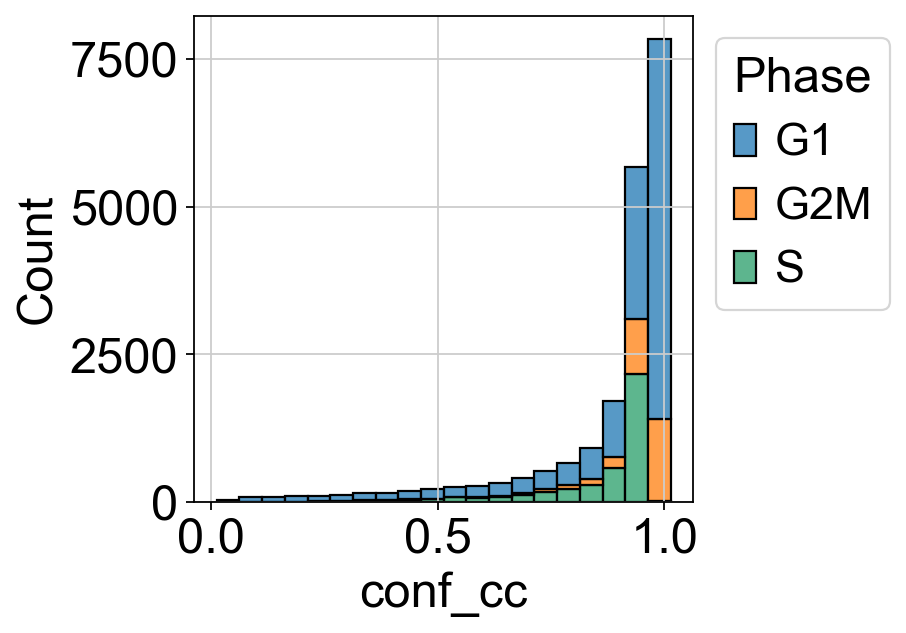

In [36]:
ax = sns.histplot(data=adata.obs, x="conf_cc", hue="Phase", multiple="stack", binwidth=0.05)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()


In [37]:
cell_type_list = list(adata.obs['cell_type'].unique())
cell_type_list.remove('stem cell')
cell_type_list.remove('transit amplifying cell of small intestine')
adata_non_stem_cells = adata[adata.obs['cell_type'].isin(cell_type_list)]
adata_stem_cells = adata[adata.obs['cell_type'].isin(['stem cell'])]
adata_transit = adata[adata.obs['cell_type'].isin(['transit amplifying cell of small intestine'])]
print(np.mean(np.array(adata_non_stem_cells.obs['conf'])))
print(np.mean(np.array(adata_transit.obs['conf'])))
print(np.mean(np.array(adata_stem_cells.obs['conf'])))
print(np.mean(np.array(adata_non_stem_cells.obs['var'])))
print(np.mean(np.array(adata_transit.obs['var'])))
print(np.mean(np.array(adata_stem_cells.obs['var'])))



0.94002616
0.78876424
0.7824704
0.15200755
0.1693227
0.17686789


In [38]:

adata.obs['conf']=adata.obs['conf_s']



In [ ]:
adata = metrics.rank_genes_conf_min_counts(adata)

In [ ]:
sc.pl.umap(adata,color=list(adata.var.sort_values(by='conf_score_high', ascending=False).index)[:5])

In [ ]:
list(adata.var.sort_values(by='conf_score_high', ascending=False).index)

In [39]:
cell_type_list = list(adata.obs['cell_type'].unique())
for celltype in cell_type_list:
    adata_tmp = adata[adata.obs['cell_type'].isin([celltype])]
    print(celltype)
    print(np.mean(adata_tmp.obs['conf_cc']))
    print(np.mean(adata_tmp.obs['var_cc']))

stem cell
0.7994959
0.14503427
transit amplifying cell of small intestine
0.85755056
0.13460746
small intestine goblet cell
0.9370349
0.111285456
enteroendocrine cell of small intestine
0.93590164
0.11661973
tuft cell of small intestine
0.95696634
0.107530184
paneth cell of epithelium of small intestine
0.84760165
0.13847648
enterocyte of epithelium of small intestine
0.955618
0.09953936


In [23]:
s_list = list(adata.obs['segment domain'].unique())
for seg in s_list:
    adata_tmp = adata[adata.obs['segment domain'].isin([seg])]
    print(seg)
    print(np.mean(adata_tmp.obs['conf_s']))
    print(np.mean(adata_tmp.obs['var_s']))

D-[18,24]
0.59401554
0.16860037
C-[10,17]
0.5563469
0.16101627
B-[3,9]
0.6086578
0.1874173
E-[25,30]
0.7635562
0.19150364
A-[1,2]
0.7499353
0.21762826
